## tradeSeq for DE along epididymal axis (epithelial spots) in male reproductive tract

In [1]:
#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("tradeSeq")

In [2]:
library(tradeSeq)
library(SingleCellExperiment)
library(slingshot)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [3]:
adata <- readRDS("/lustre/scratch126/cellgen/team292/vl6/VISIUM/epididymalaxis_epi_downsampled_cytassist.rds")
adata


class: SingleCellExperiment 
dim: 15352 194 
metadata(0):
assays(1): X
rownames(15352): SAMD11 NOC2L ... DEPRECATED_ENSG00000275464
  DEPRECATED_ENSG00000276085
rowData names(2): n_cells n_counts
colnames(194): HCA_F_RepTsp14733322_AACCACTGCCATAGCC-1
  HCA_F_RepTsp14733322_AACCGCCAGACTACTT-1 ...
  HCA_F_RepTsp14707486_TGTATGCCTATCTTAT-1
  HCA_F_RepTsp14707486_TGTCAAGCGGATCGGT-1
colData names(71): in_tissue array_row ... Epididymis_Epi_combined
  binned_Epididymal_Axis_3_bins
reducedDimNames(0):
altExpNames(0):

In [4]:
counts <- assay(adata, "X")

In [5]:
set.seed(7)
pseudotime <- colData(adata)$Epididymal_Axis
cellWeights <- rep(1, 194)

In [6]:
#icMat <- evaluateK(counts = counts, sds = SlingshotDataSet(adata), k = 3:10, 
#                   nGenes = 200, verbose = T)

In [7]:
library(scran)

In [8]:
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(adata) <- log2(t(t(counts)/size.factors) + 1)
assayNames(adata)

[1] "X"         "logcounts"

In [9]:
# Filter genes with non-zero biological components
getVariableGenes <- function(adata,fdr_thresh=NULL,var_thresh=0) {
  gene_var <- modelGeneVar(adata)
  genes <- getTopHVGs(gene_var, var.threshold =var_thresh ,fdr.threshold = fdr_thresh)
  return(genes)
}

In [10]:
genes <- getVariableGenes(adata)

In [11]:
length(genes)

[1] 8114

In [12]:
dim(counts[genes,])

[1] 8114  194

In [13]:
sce <- fitGAM(counts = counts[genes,], pseudotime = pseudotime, cellWeights = cellWeights, nknots = 5,
                verbose = TRUE, parallel = TRUE)

  |======================================================================| 100%



In [14]:
table(rowData(sce)$tradeSeq$converged)


TRUE 
8114 

In [15]:
adata <- adata[genes, ]

In [16]:
adata

class: SingleCellExperiment 
dim: 8114 194 
metadata(0):
assays(2): X logcounts
rownames(8114): KRT17 DEPRECATED_ENSG00000128422 ... USP50 SYCP3
rowData names(2): n_cells n_counts
colnames(194): HCA_F_RepTsp14733322_AACCACTGCCATAGCC-1
  HCA_F_RepTsp14733322_AACCGCCAGACTACTT-1 ...
  HCA_F_RepTsp14707486_TGTATGCCTATCTTAT-1
  HCA_F_RepTsp14707486_TGTCAAGCGGATCGGT-1
colData names(71): in_tissue array_row ... Epididymis_Epi_combined
  binned_Epididymal_Axis_3_bins
reducedDimNames(0):
altExpNames(0):

### ASSOCIATION TEST

A first exploration of the data analysis may consist of checking whether gene expression is associated with a particular lineage. The statistical test performed here, implemented in the associationTest function, is testing the null hypothesis that all smoother coefficients are equal to each other. This can be interpreted as testing whether the average gene expression is significantly changing along pseudotime.



In [17]:
assoRes <- associationTest(sce)
head(assoRes)

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
KRT17,209.3508,3,0,1.8278103
DEPRECATED_ENSG00000128422,209.9139,3,0,1.7107676
PDK4,453.1133,3,0,1.7972414
MUC6,436.8303,3,0,0.9570644
EPHA7,383.0475,3,0,1.8648002
TPPP3,419.6441,3,0,1.1033008


In [18]:
write.csv(assoRes, file = '/nfs/team292/vl6/FetalReproductiveTract/manuscript_v1/supp_tables/SupplementaryTable8_epididymis_epi_cytassist.csv')


In order to discover marker genes of the progenitor or differentiated cell population, researchers may be interested in assessing differential expression between the progenitor cell population (i.e., the starting point of a lineage) with the differentiated cell type population (i.e., the end point of a lineage). The function startVsEndTest uses a Wald test to assess the null hypothesis that the average expression at the starting point of the smoother (progenitor population) is equal to the average expression at the end point of the smoother (differentiated population). The test basically involves a comparison between two smoother coefficients for every lineage. The function startVsEndTest performs a global test across all lineages by default (i.e. it compares the start and end positions for all lineages simultaneously), but you can also assess all lineages separately by setting lineages=TRUE. Below, we adopt an omnibus test across the two lineages.

In [19]:
assoRes = assoRes[assoRes$pvalue < 0.001,]

In [20]:
dim(assoRes)

[1] 2672    4

In [21]:
assoRes['VIL1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
VIL1,120.2489,3,0,2.962366


In [22]:
assoRes['ESR1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
ESR1,128.2193,3,0,0.9817265


In [23]:
assoRes['WNT9B', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
WNT9B,86.01949,3,0,0.3349045


In [24]:
assoRes['GATA3', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
GATA3,293.2082,3,0,1.008778


In [25]:
assoRes = assoRes[assoRes$meanLogFC > 0.5, ]

In [26]:
dim(assoRes)

[1] 1266    4

In [41]:
assoRes = assoRes[assoRes$waldStat > 80, ]

In [42]:
dim(assoRes)

[1] 485   4

In [43]:
write.csv(assoRes, file = "/lustre/scratch126/cellgen/team292/vl6/VISIUM/EpididymalAxis_epi_genes.csv",
          row.names = TRUE)

In [44]:
model_vals_df <- predictSmooth(models = sce, gene=row.names(assoRes), nPoints=100) 

In [45]:
model_vals_mtx <- predictSmooth(models = sce, gene=row.names(assoRes), nPoints=100, tidy=FALSE)

In [46]:
write.csv(model_vals_mtx, file = '/lustre/scratch126/cellgen/team292/vl6/VISIUM/epididymis_visium_fitted_values_tradeseq_epithelium_mesenchyme.csv')


In [47]:
head(assoRes, 30)

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
KRT17,209.3508,3,0,1.8278103
DEPRECATED_ENSG00000128422,209.9139,3,0,1.7107676
PDK4,453.1133,3,0,1.7972414
MUC6,436.8303,3,0,0.9570644
EPHA7,383.0475,3,0,1.8648002
TPPP3,419.6441,3,0,1.1033008
CLDN2,408.9664,3,0,1.3182539
CFAP157,299.7279,3,0,1.6153228
C20orf85,170.5332,3,0,3.4420092


In [48]:
library(ggplot2)

In [39]:
# Get the index of the DataFrame
tops <- row.names(assoRes)[100:150]

[1] "GLYAT"
[1] "GRHL2"


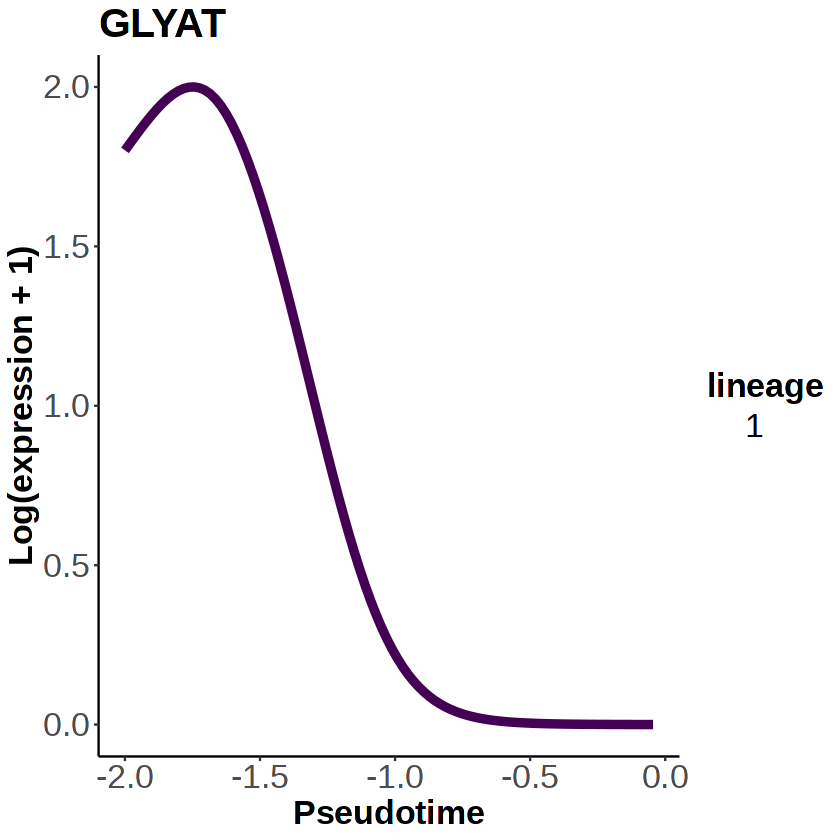

[1] "DLK1"


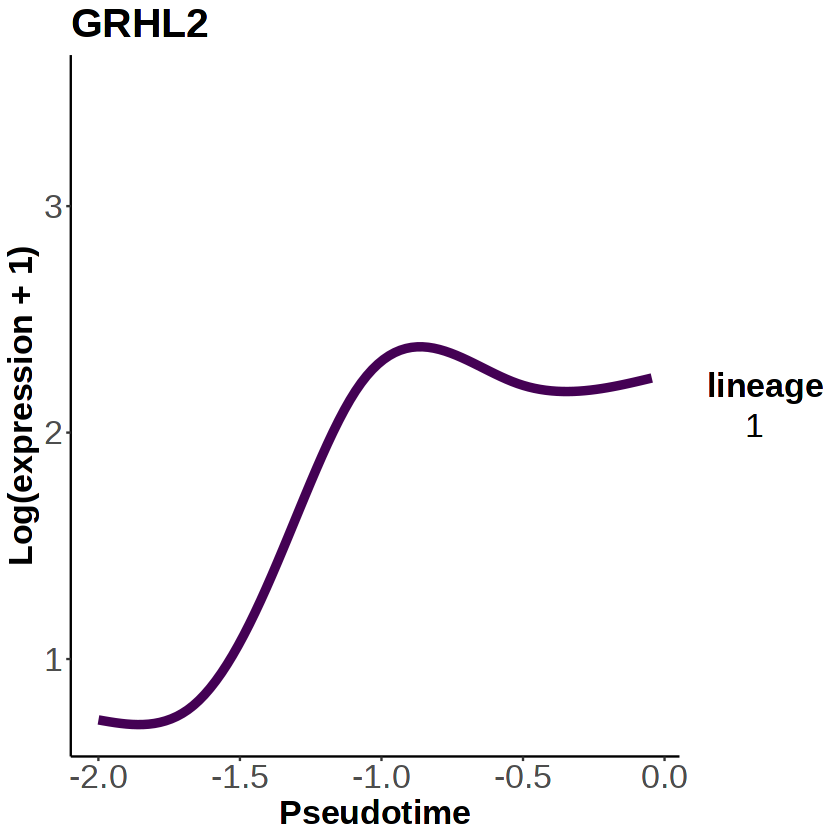

[1] "ANXA13"


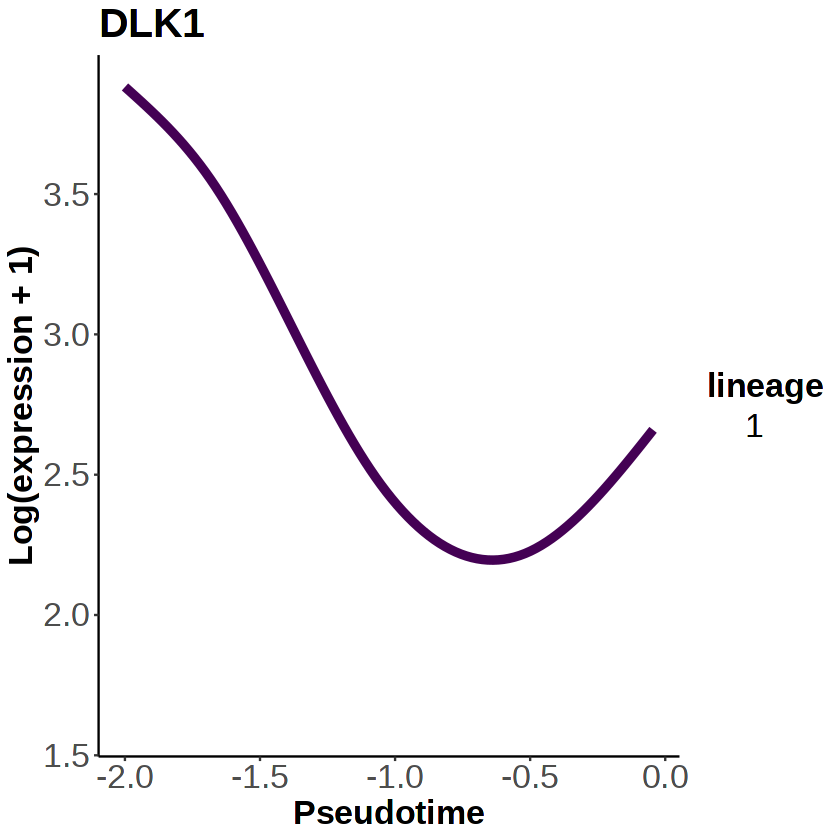

[1] "OTULINL"


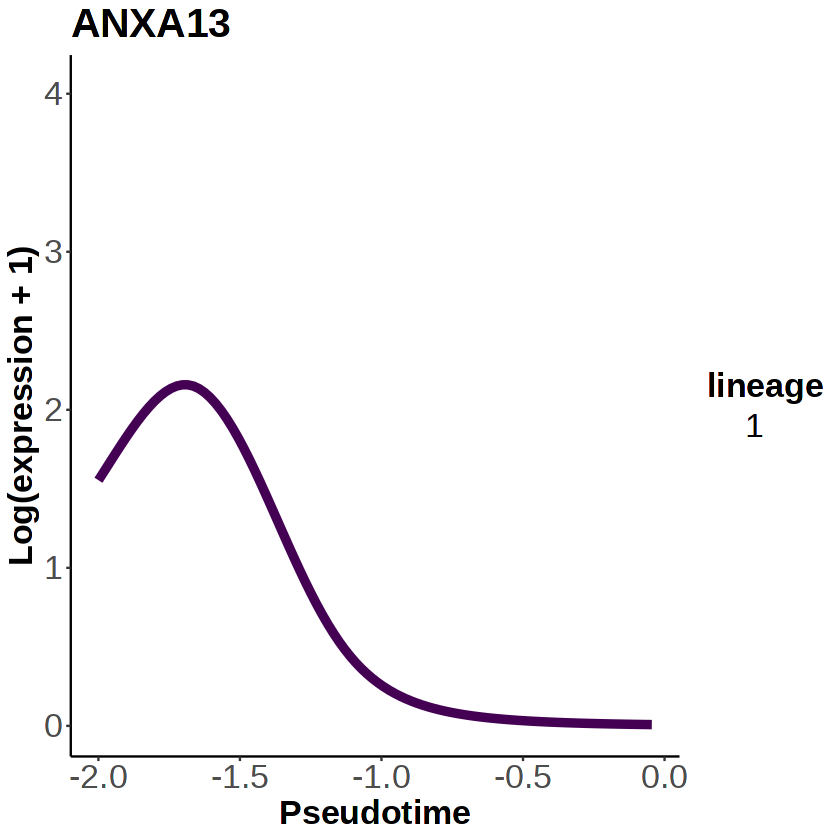

[1] "TNNT3"


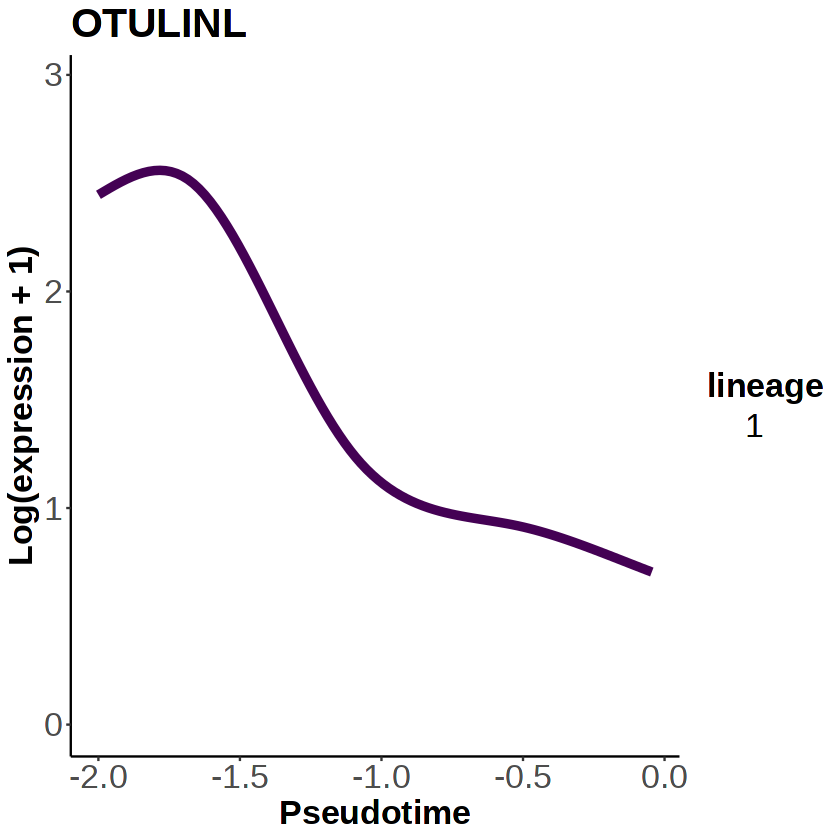

[1] "C1orf194"


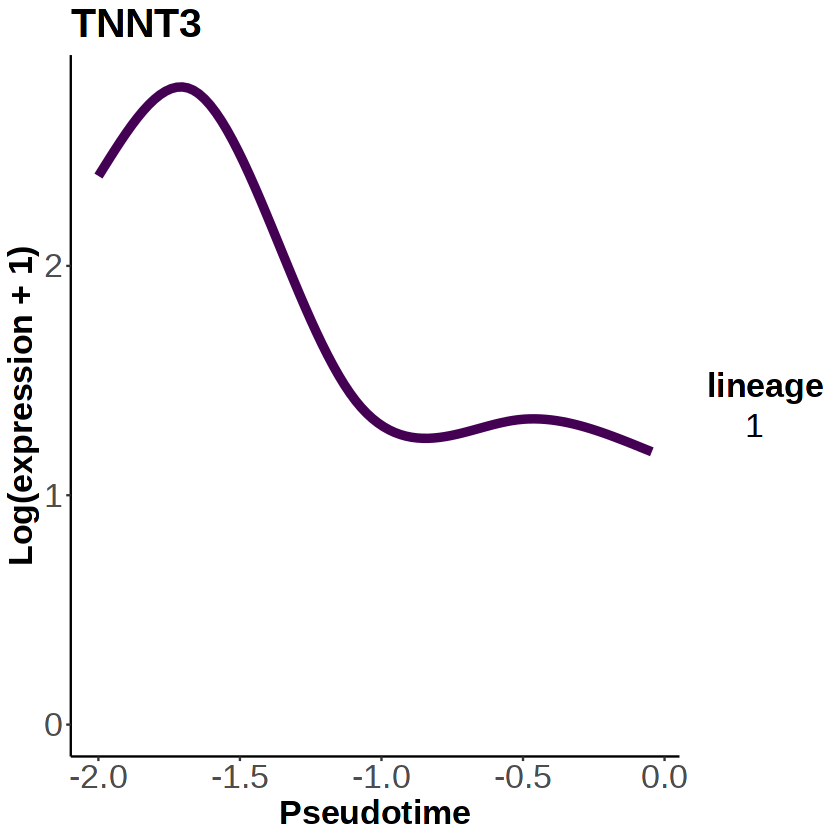

[1] "UGT2A3"


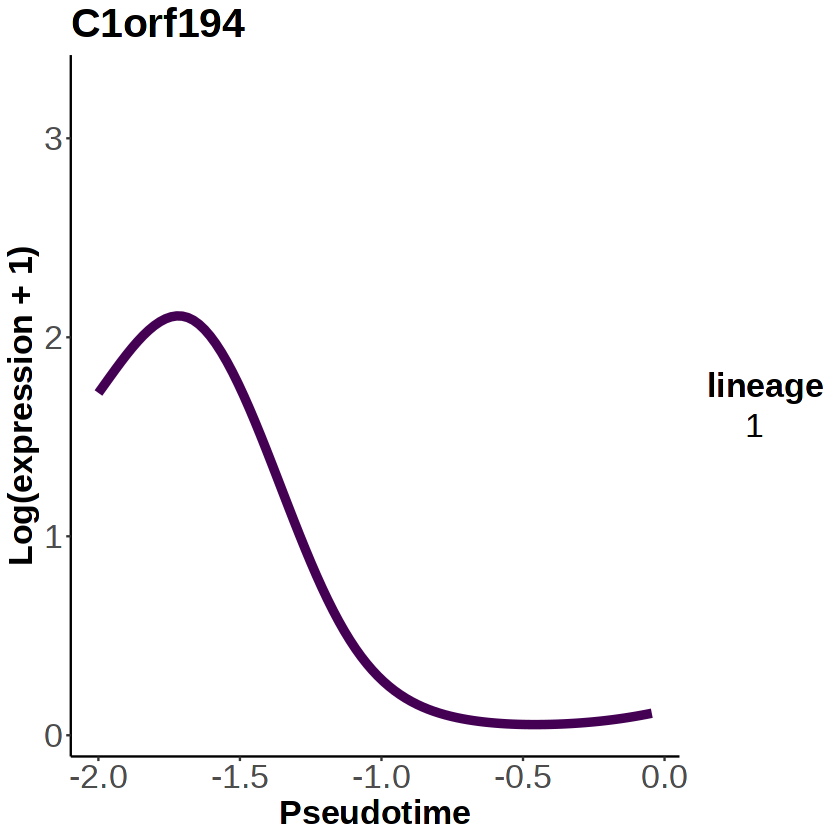

[1] "TEKT2"


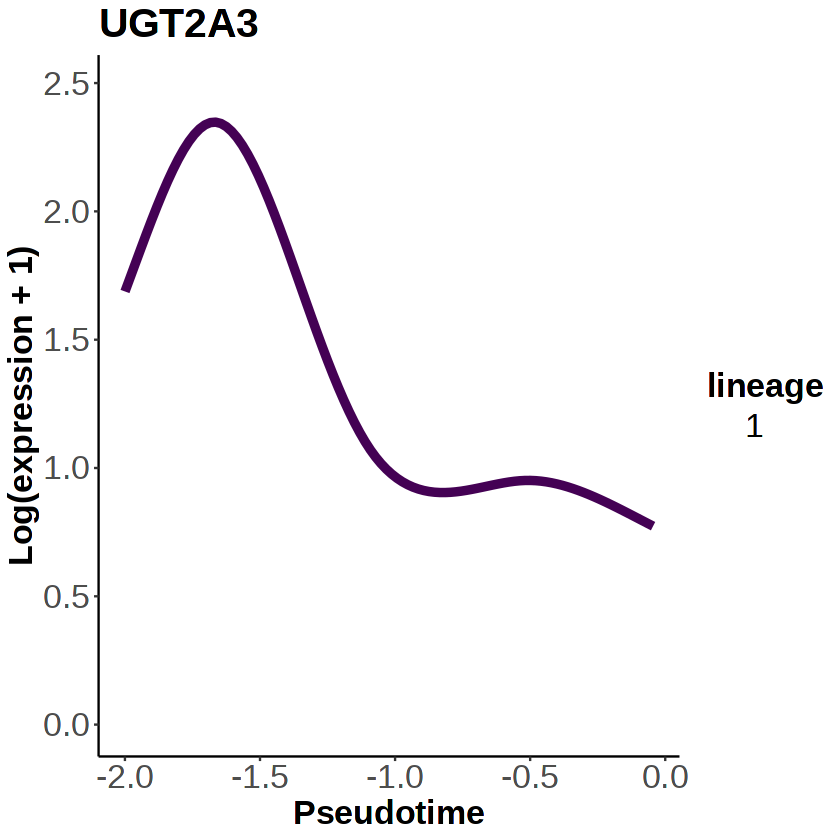

[1] "MAL2"


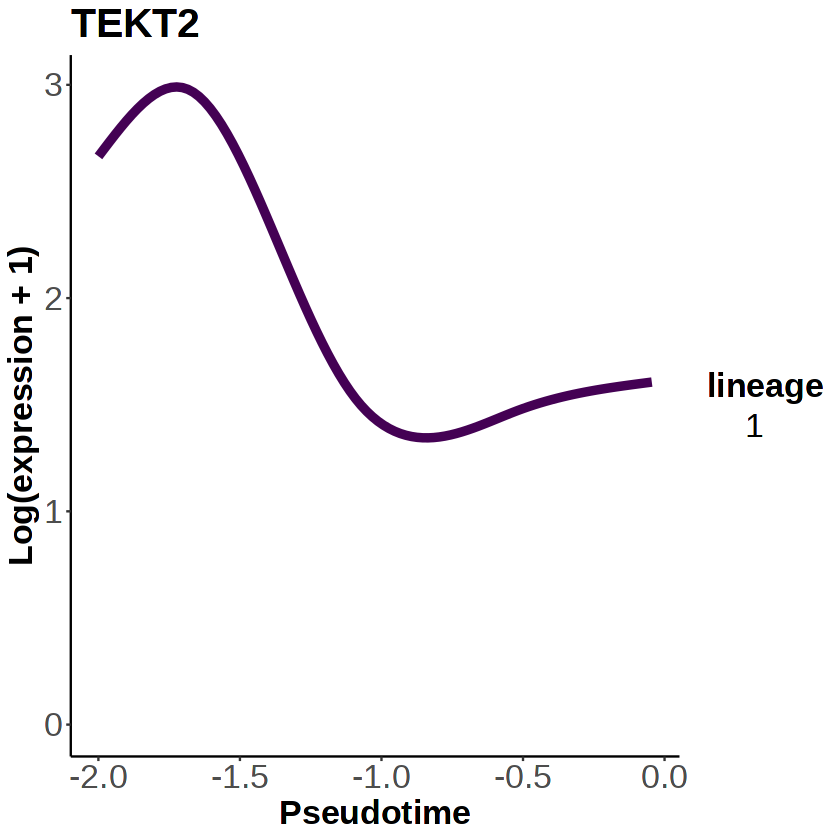

[1] "CFAP73"


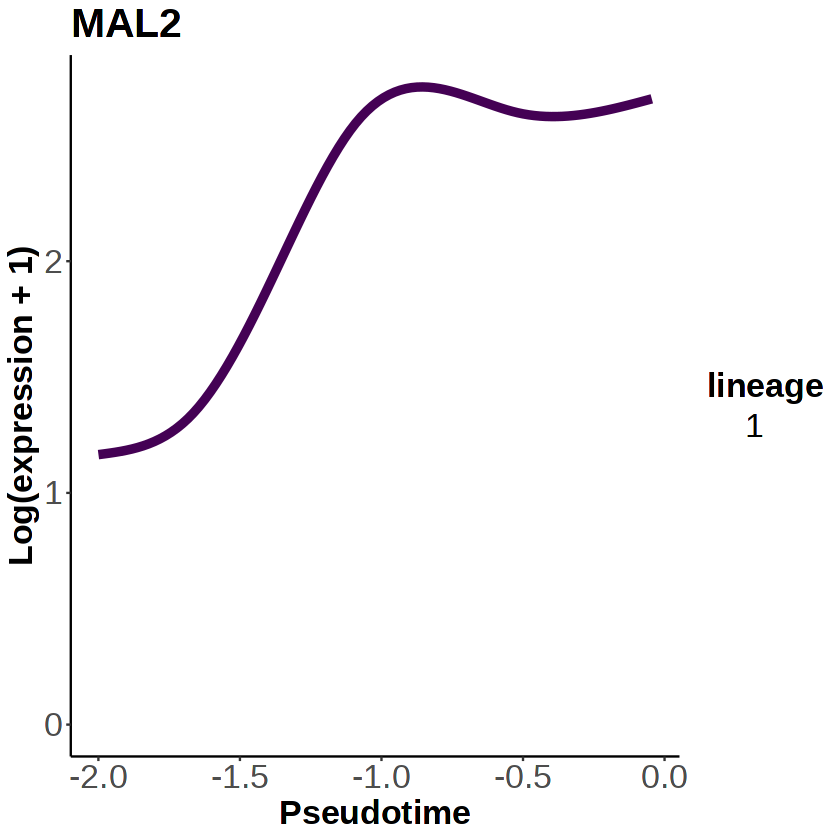

[1] "BHMT"


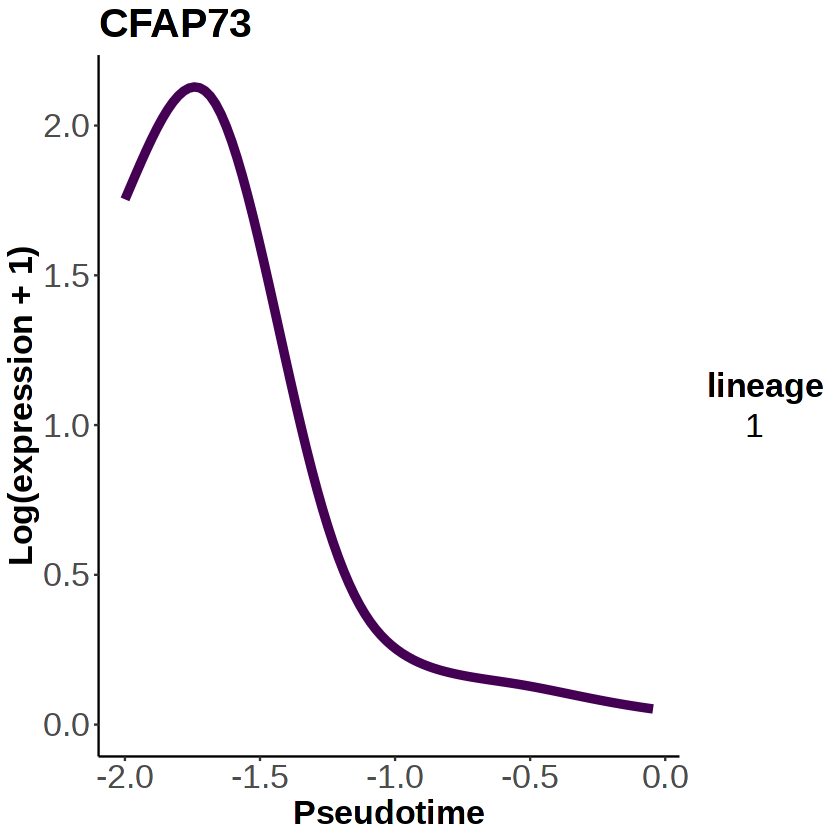

[1] "CDH3"


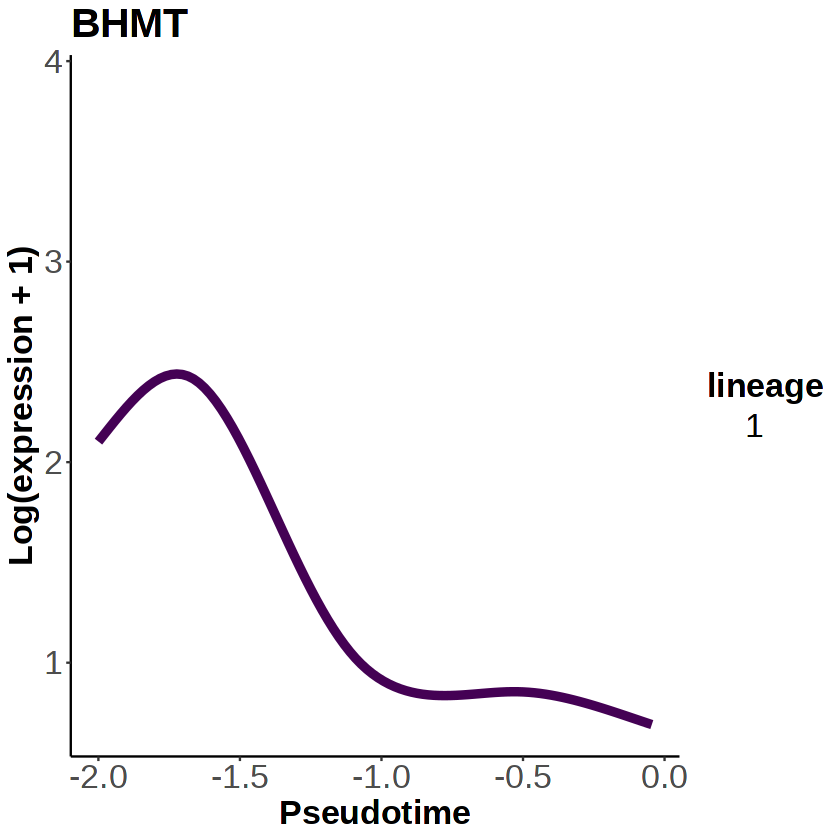

[1] "MOXD1"


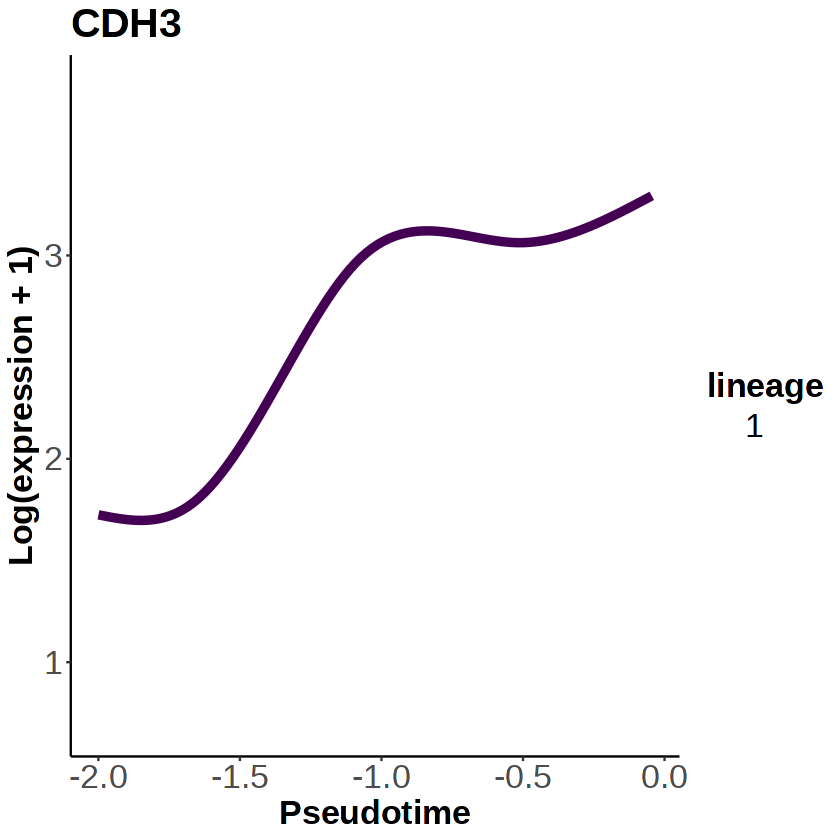

[1] "GATA6"


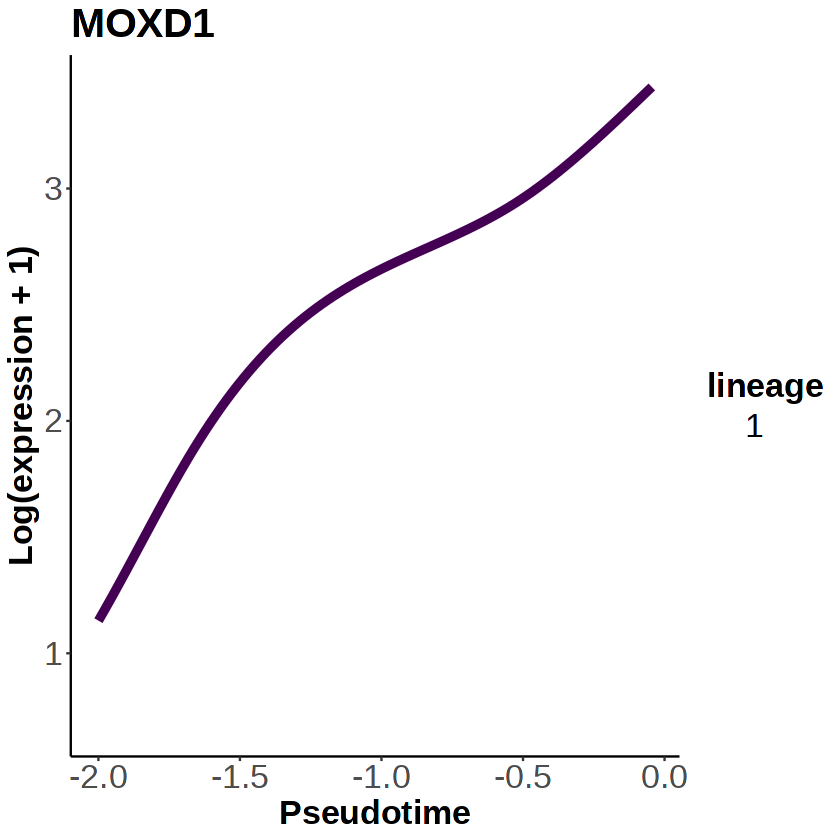

[1] "AC007906.2"


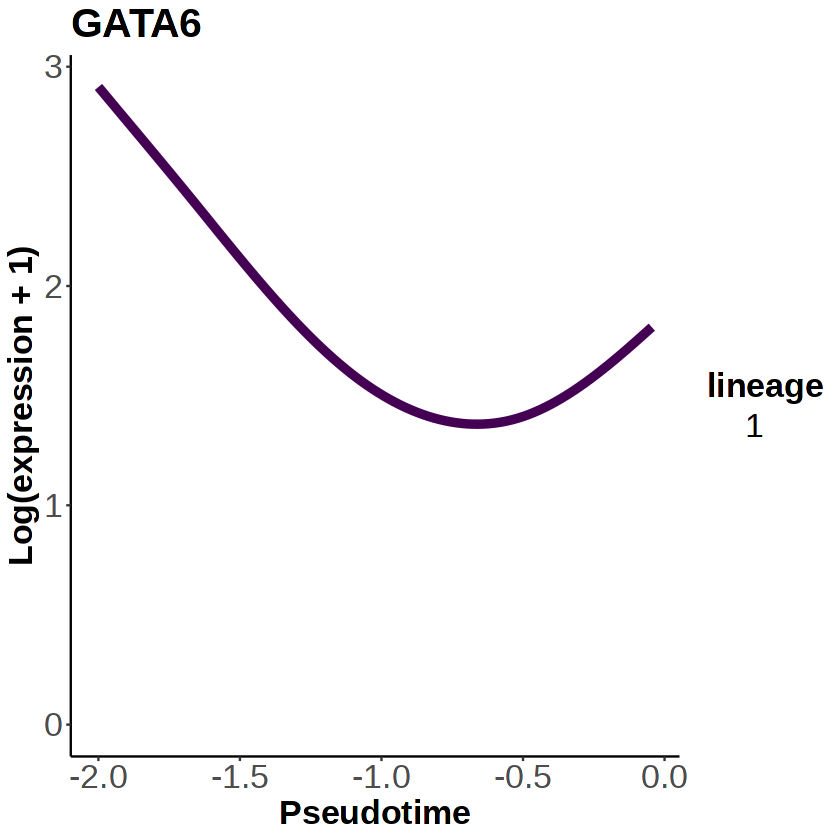

[1] "MT2A"


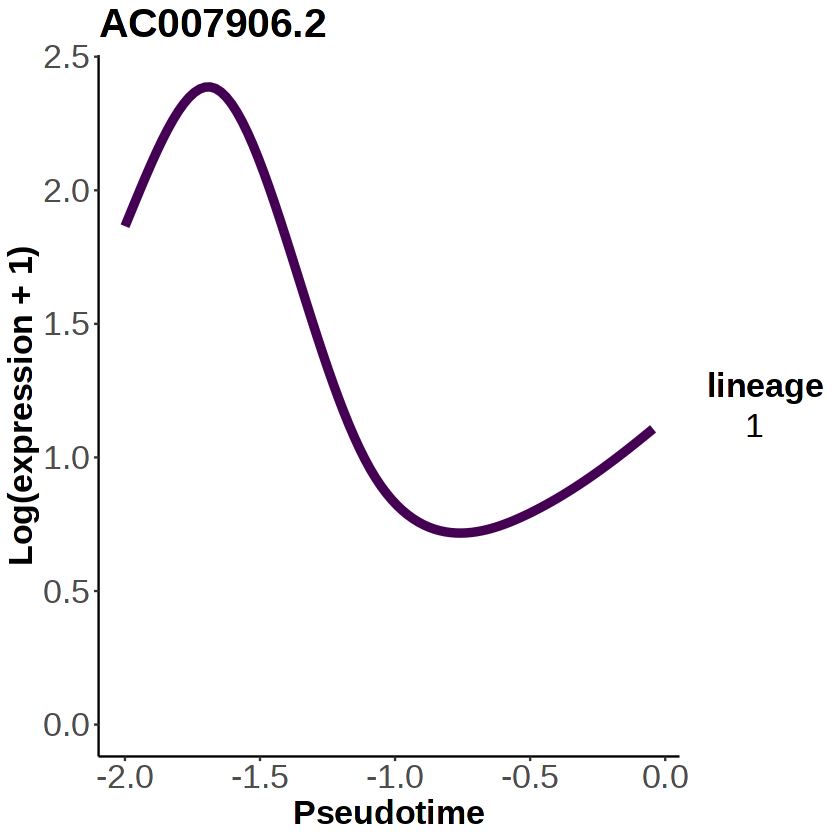

[1] "MSLN"


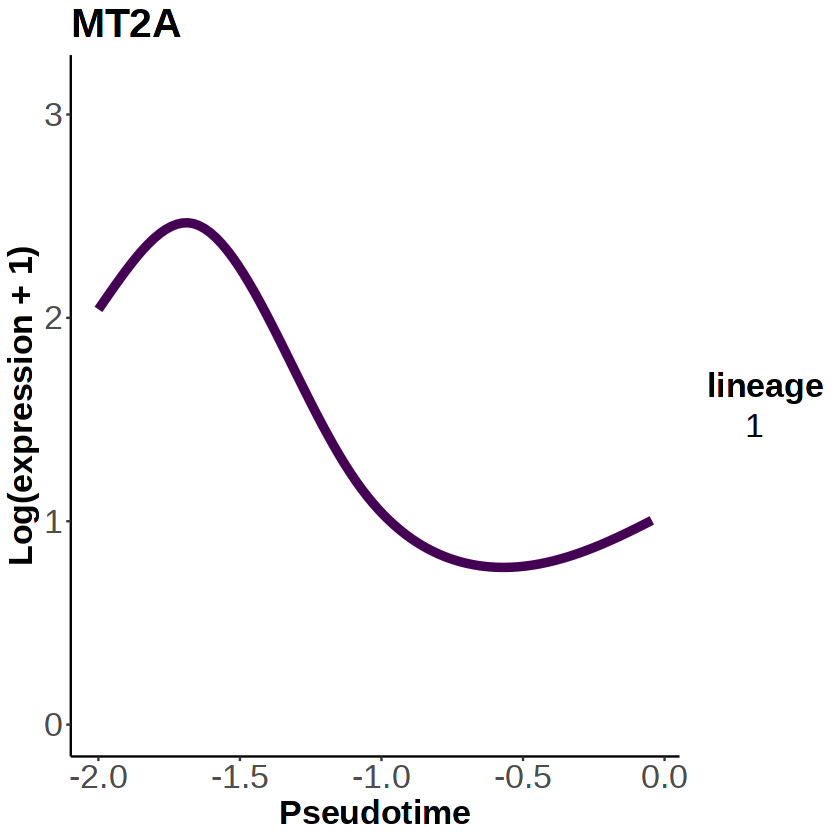

[1] "DNAJB13"


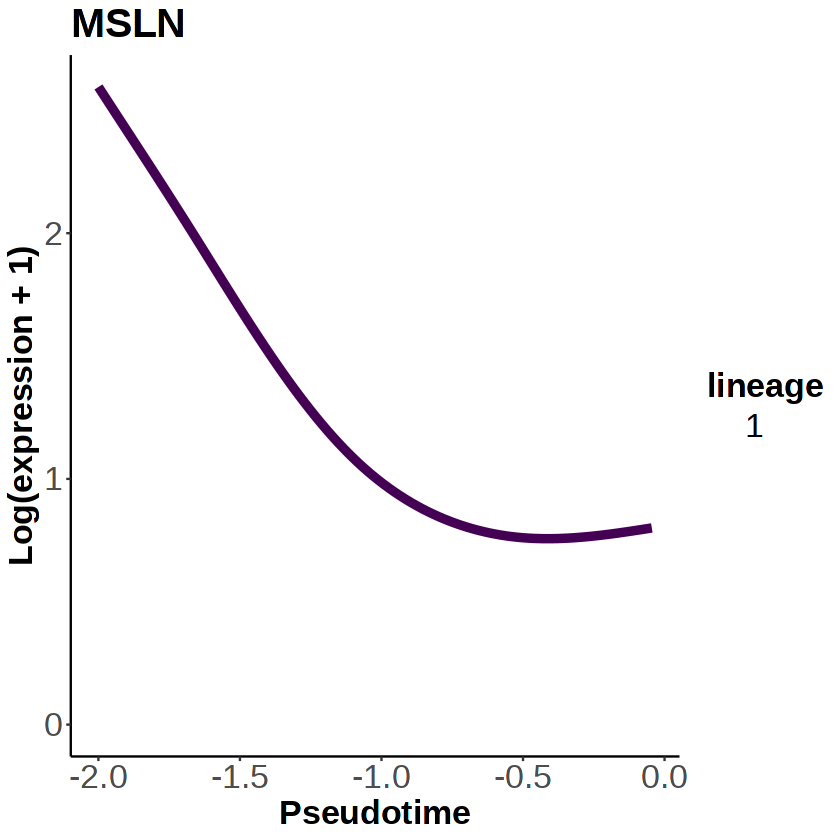

[1] "CDH2"


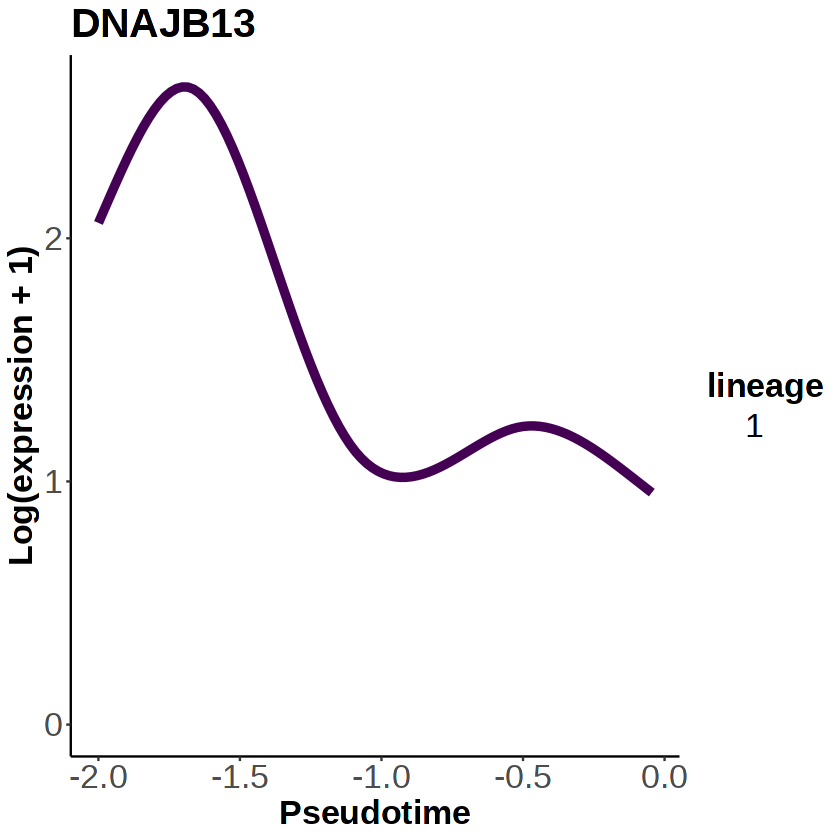

[1] "CPLX2"


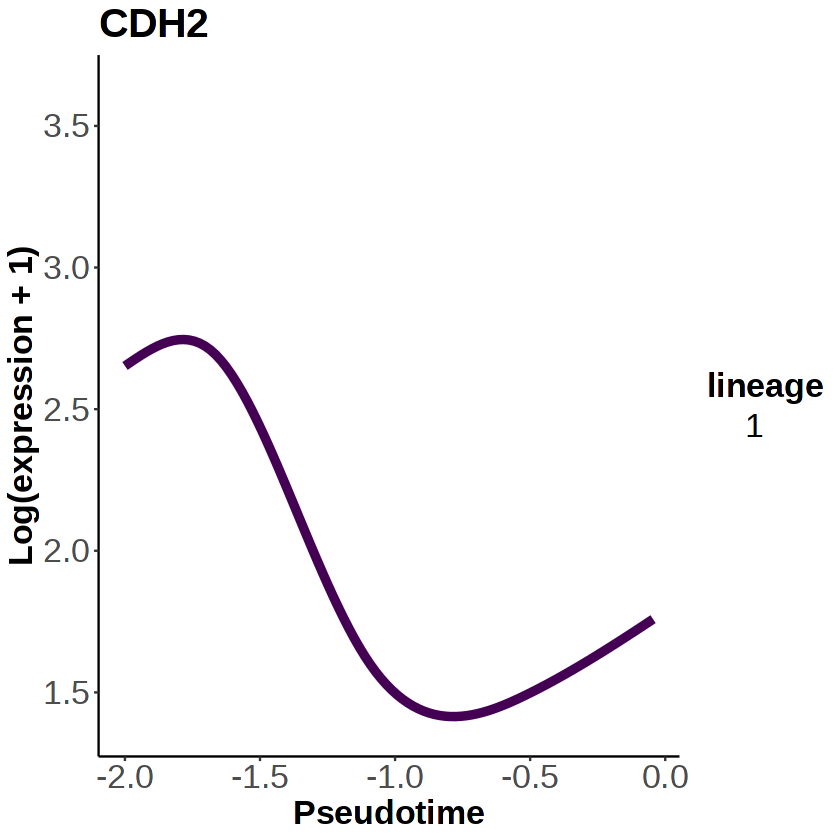

[1] "LRRC71"


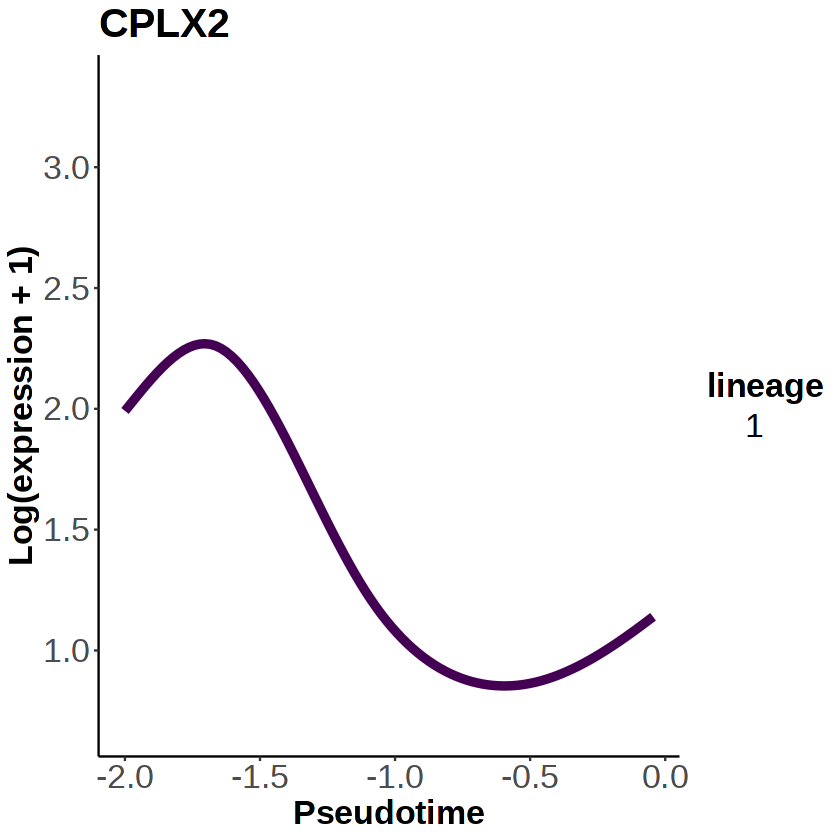

[1] "WIF1"


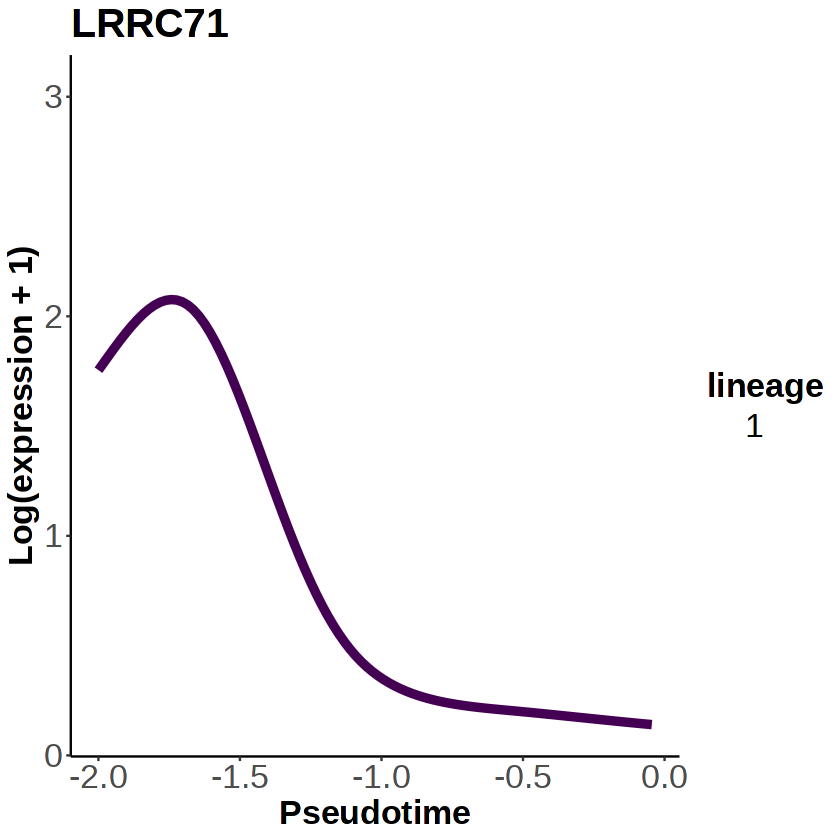

[1] "FAM92B"


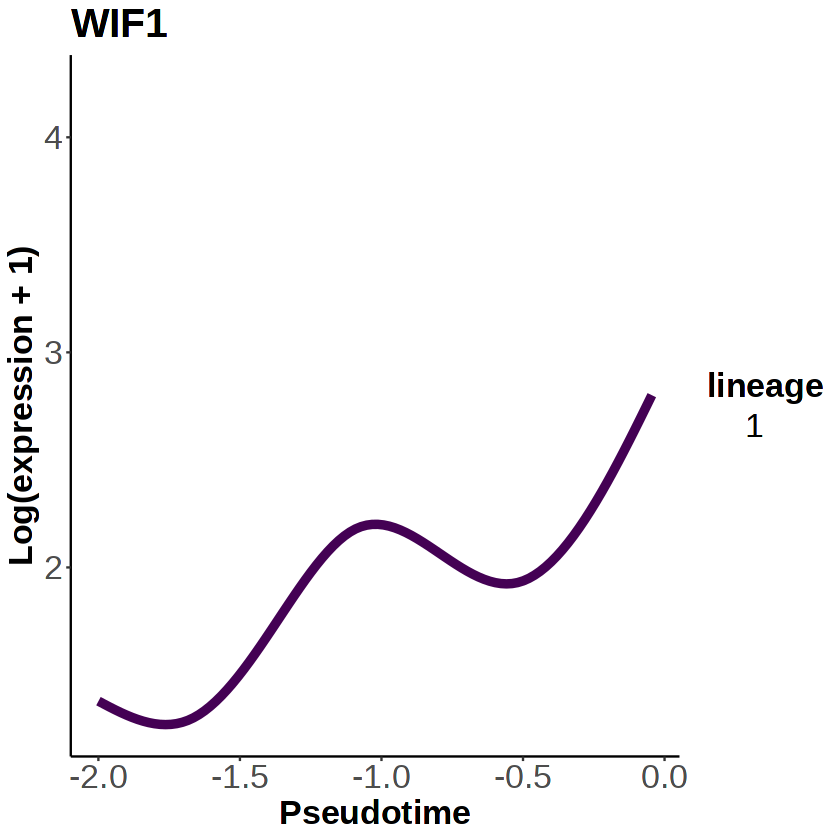

[1] "HGD"


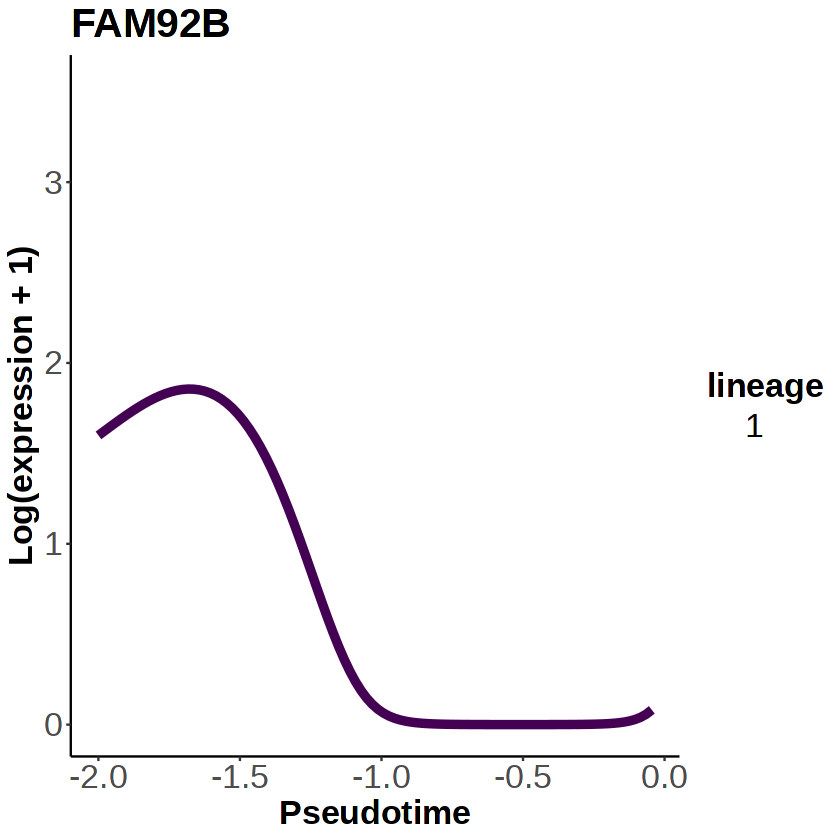

[1] "CDHR4"


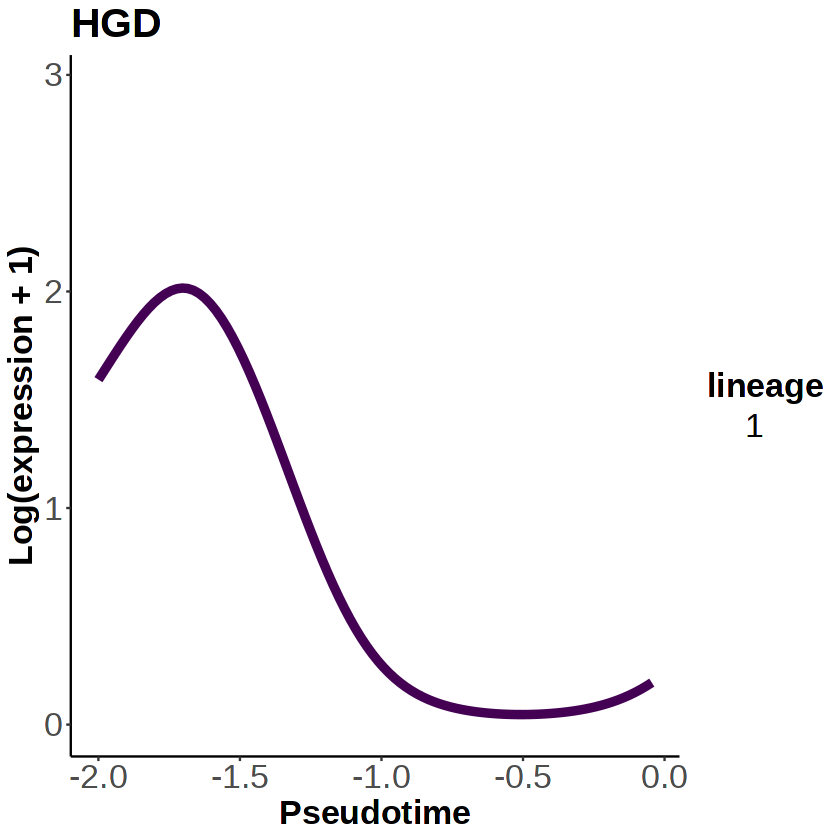

[1] "RNF128"


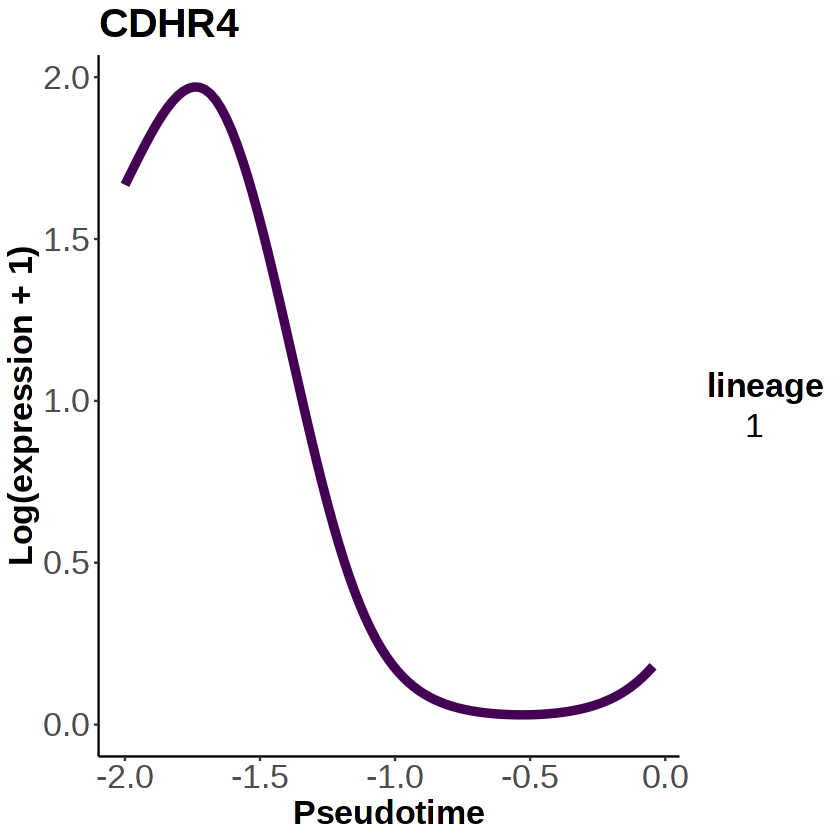

[1] "HOXB9"


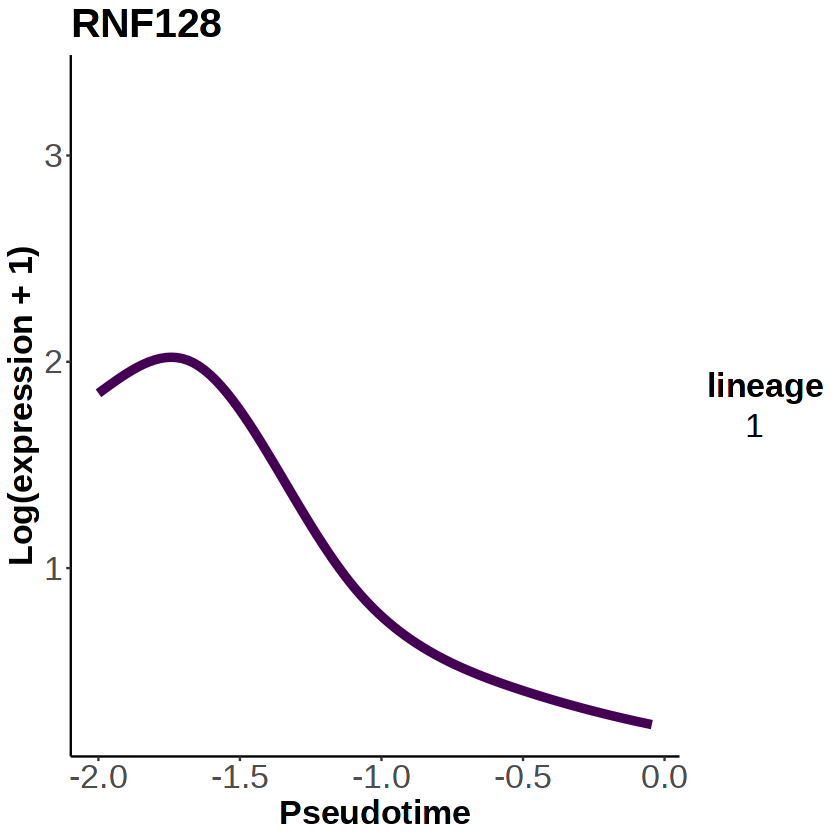

[1] "S100A14"


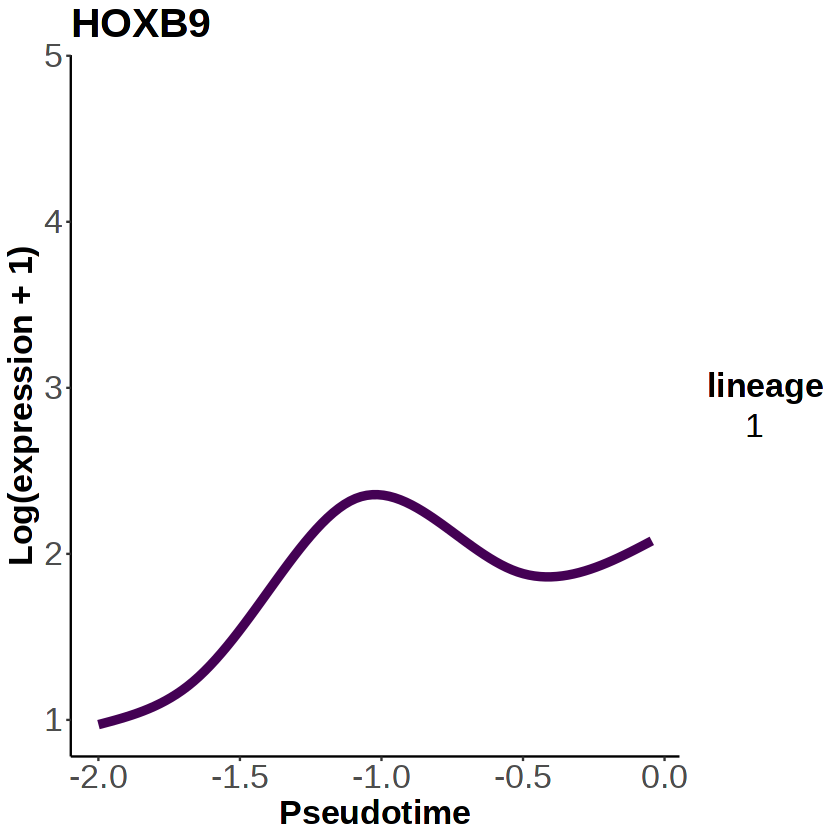

[1] "BVES"


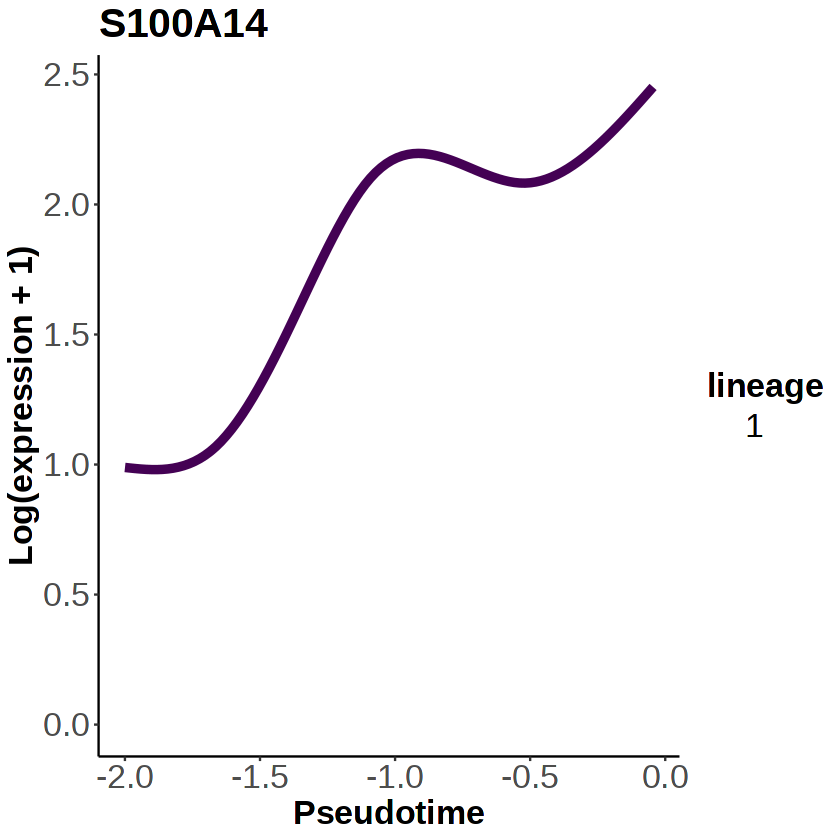

[1] "EDN2"


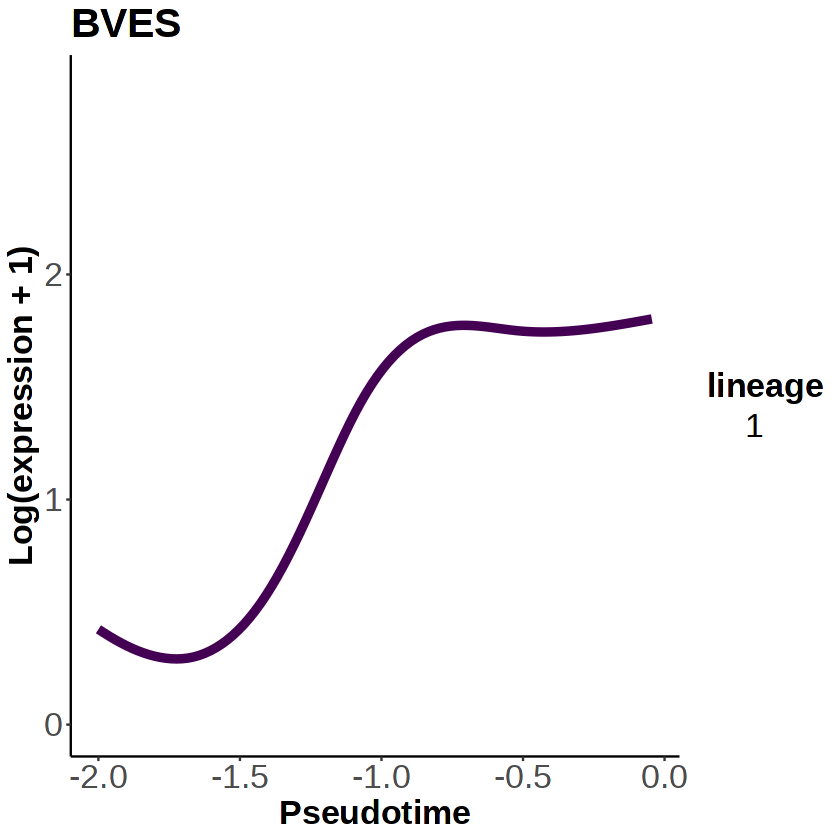

[1] "TSPAN12"


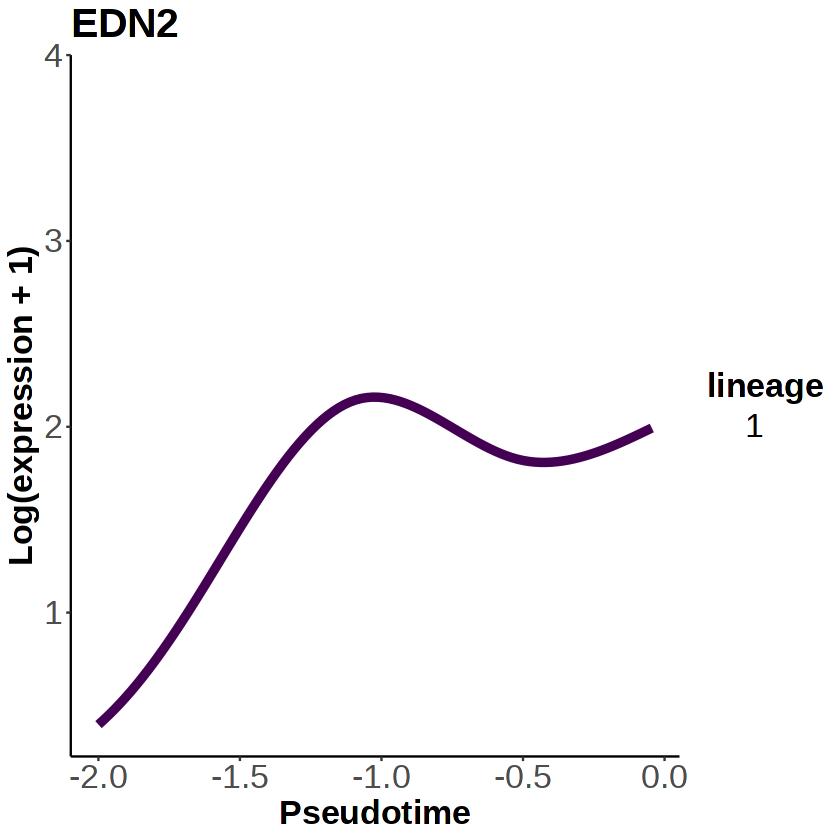

[1] "CA12"


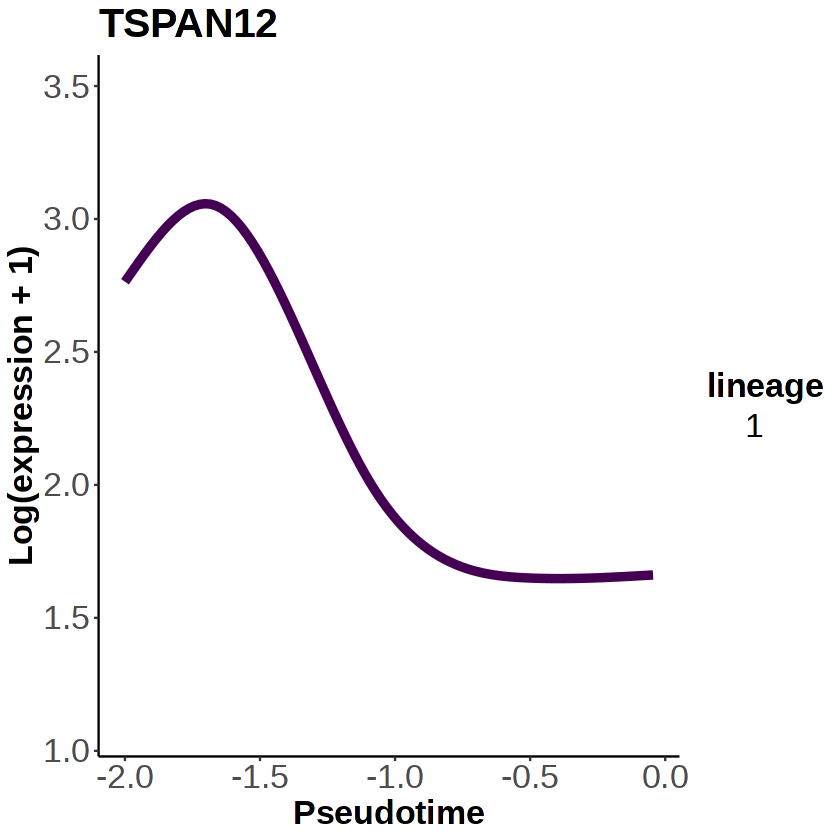

[1] "ENPP2"


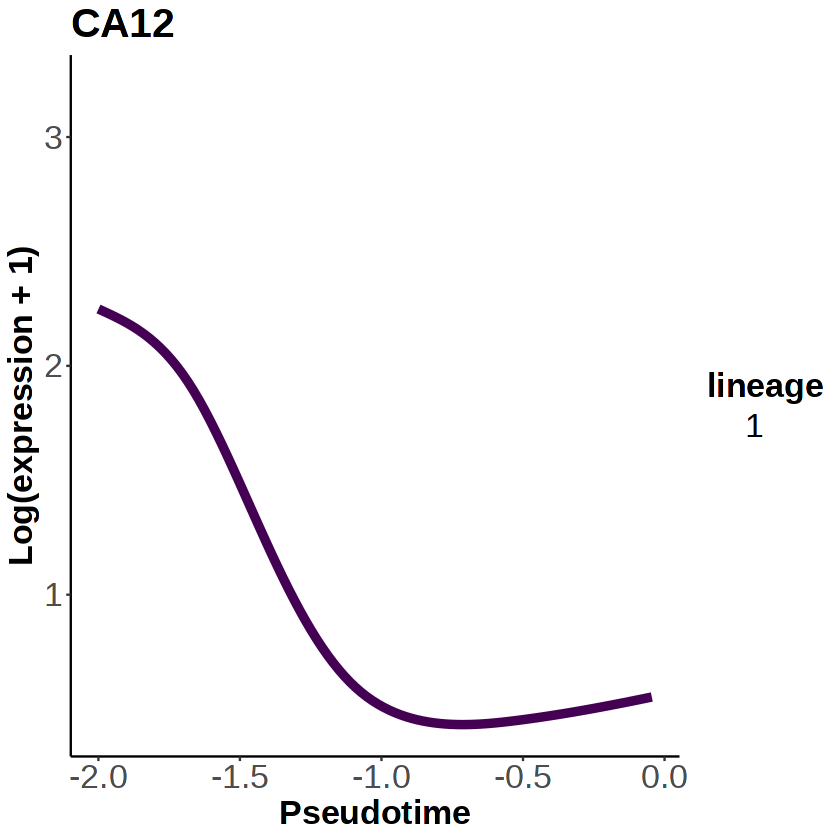

[1] "DRC1"


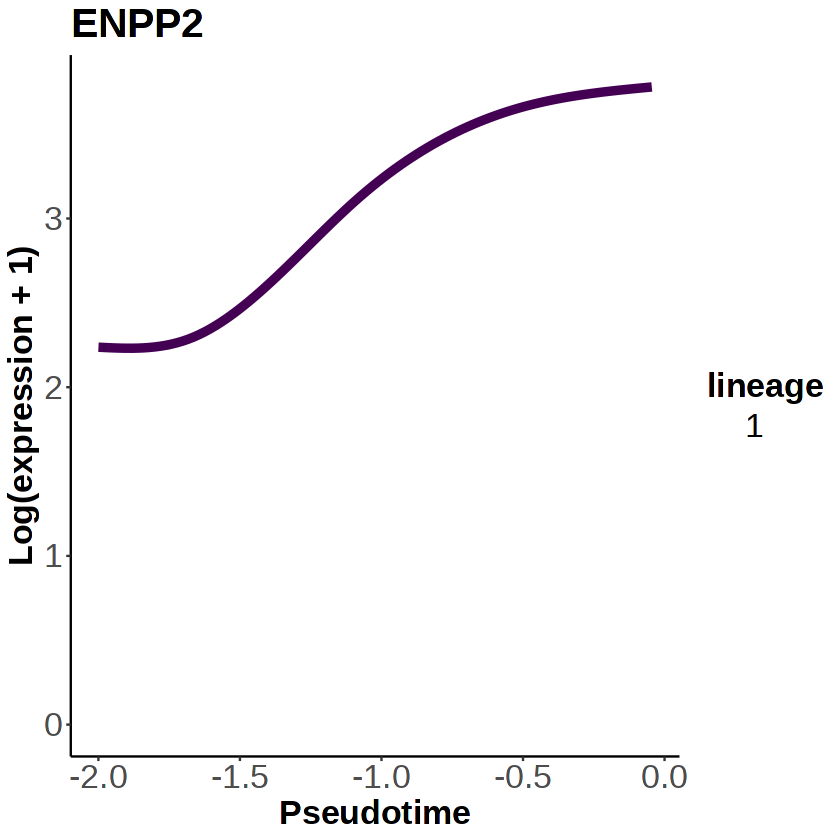

[1] "NTN1"


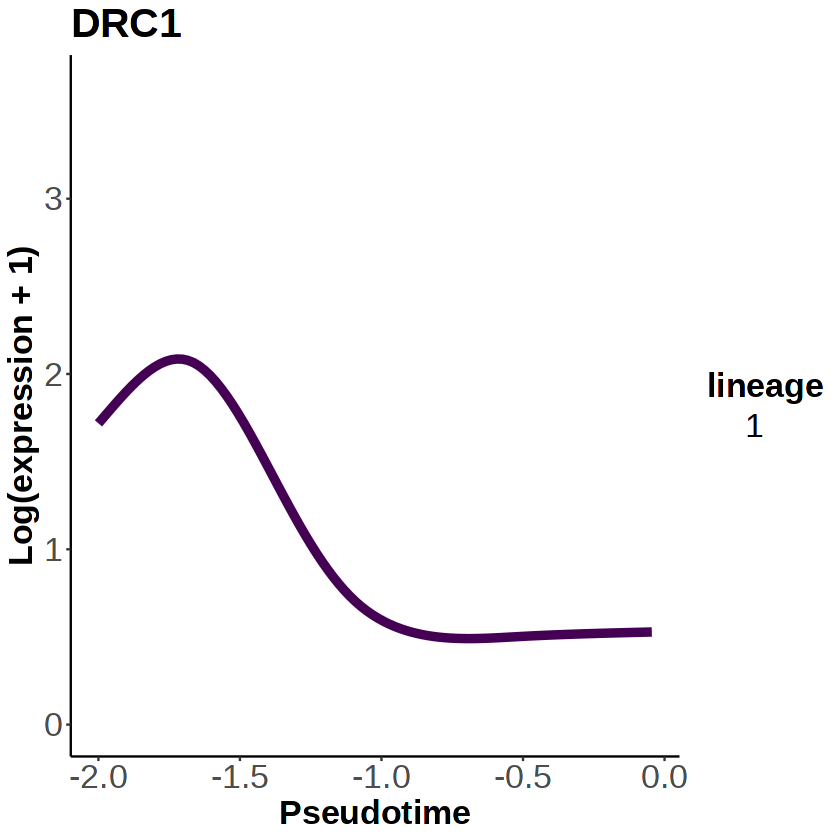

[1] "WDR72"


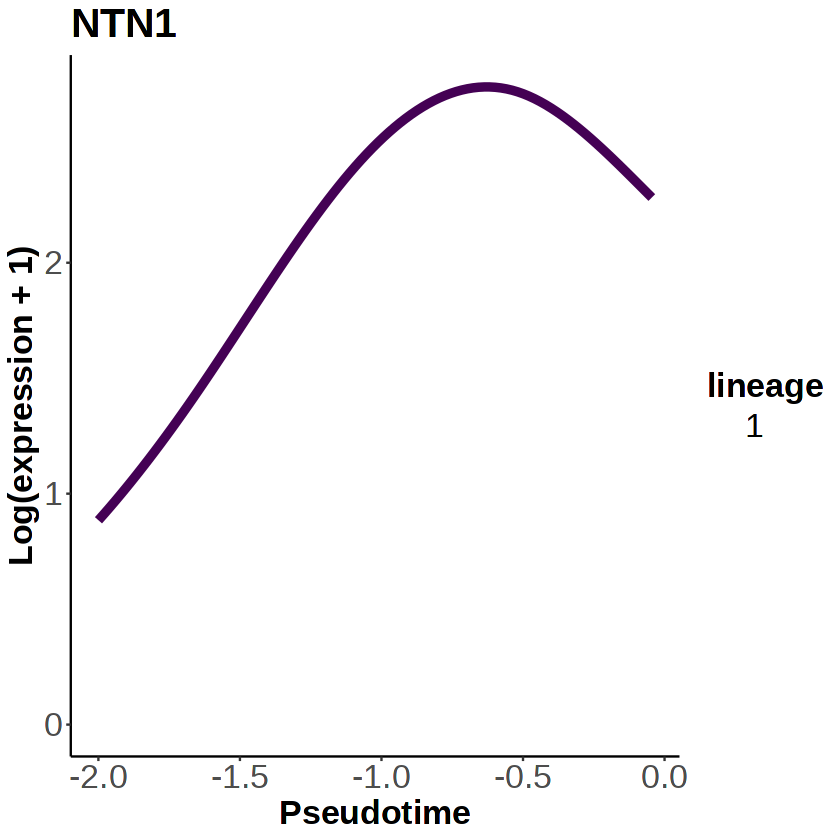

[1] "PRDM16"


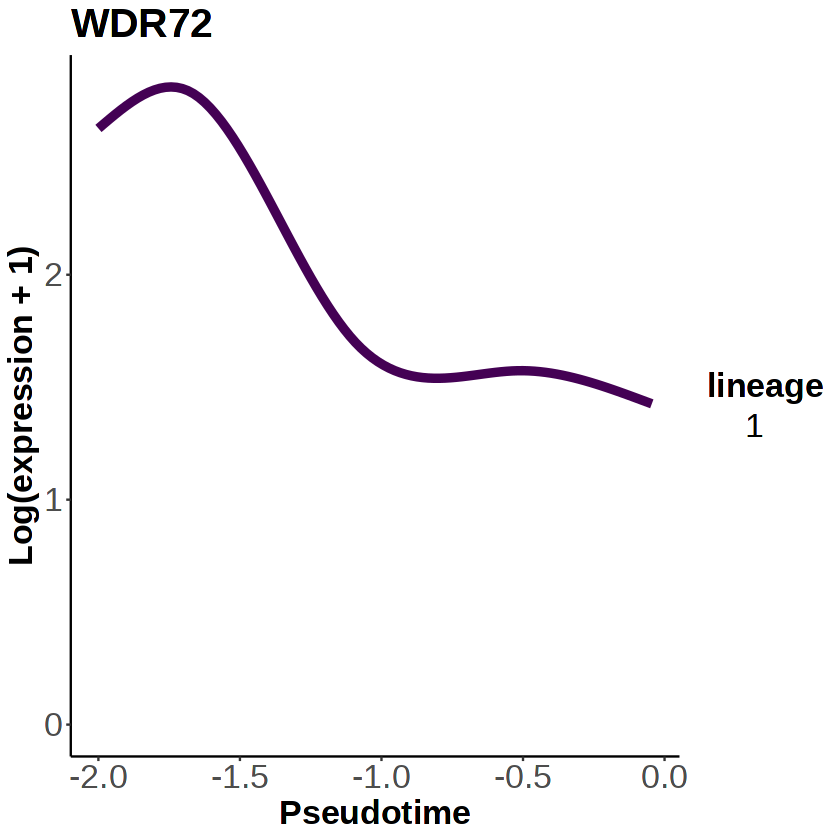

[1] "SMIM24"


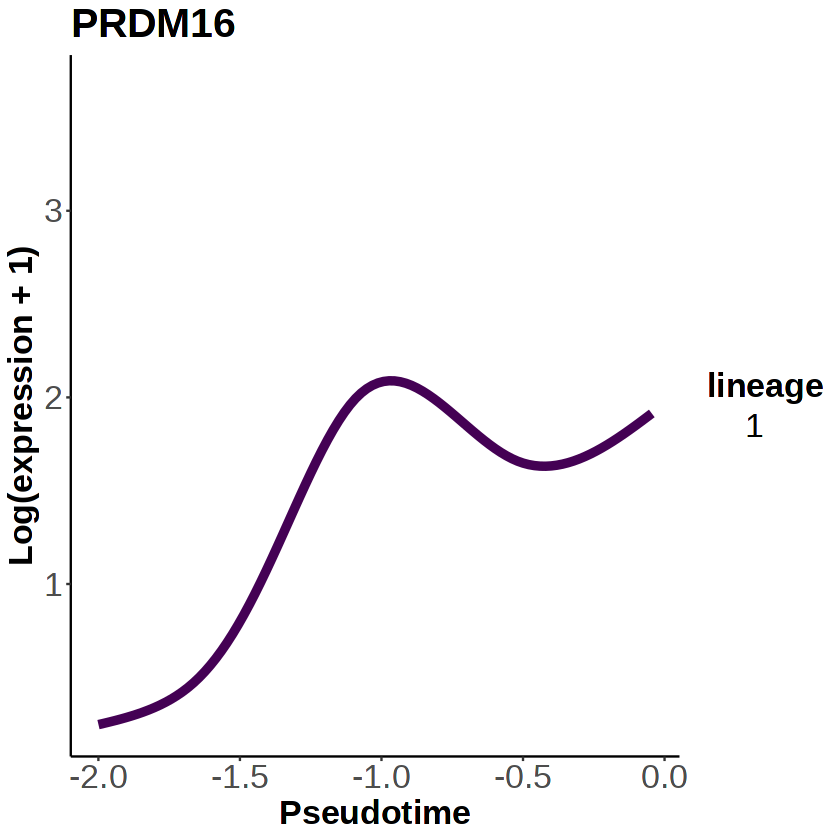

[1] "BICDL1"


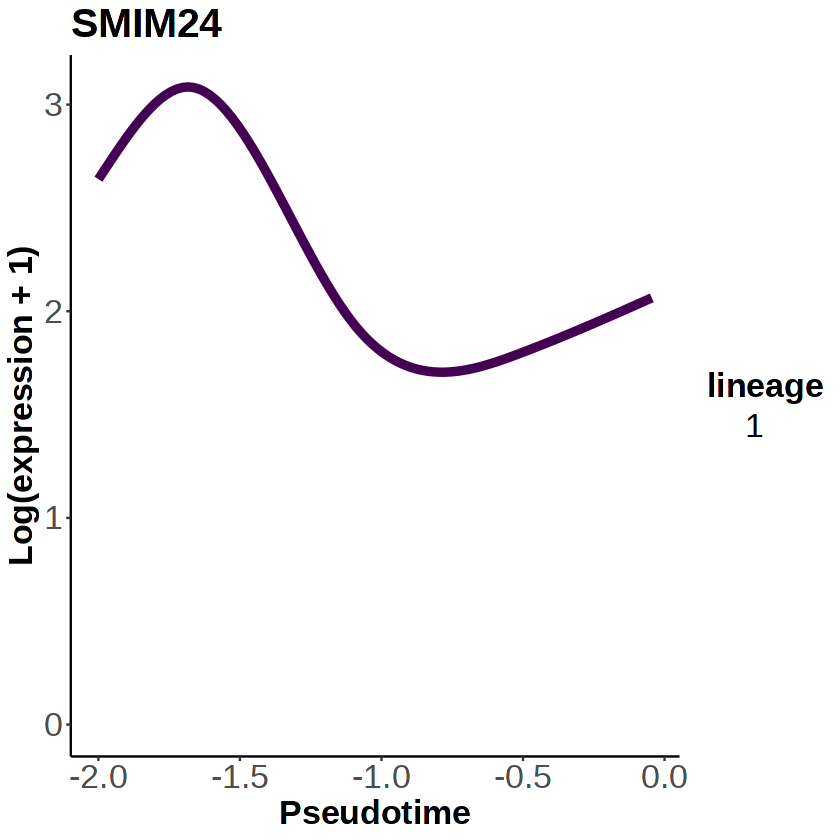

[1] "NNAT"


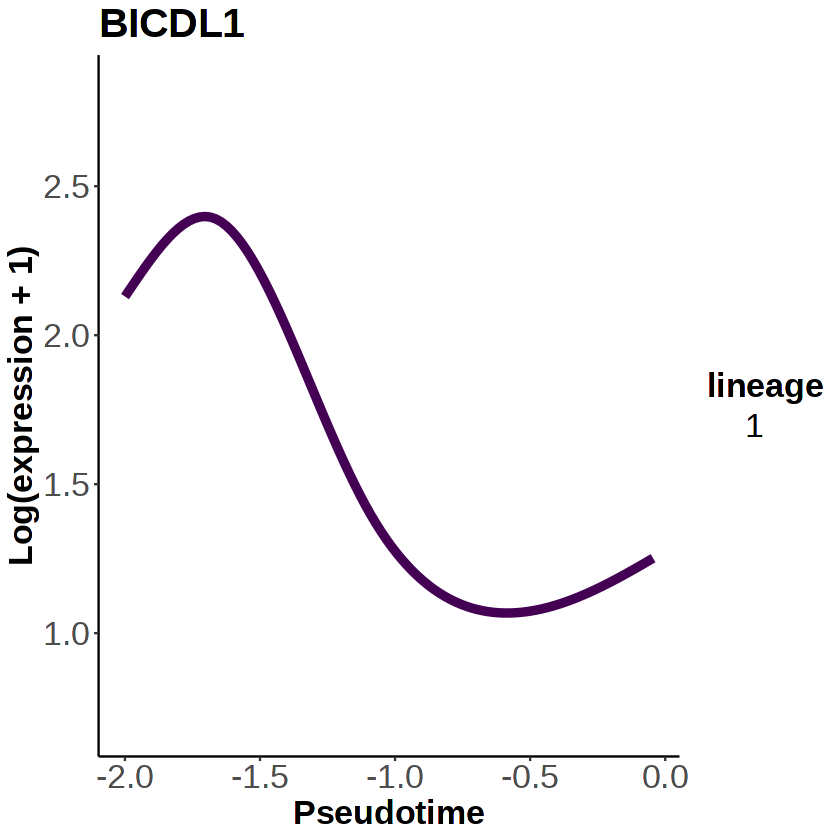

[1] "NAPSA"


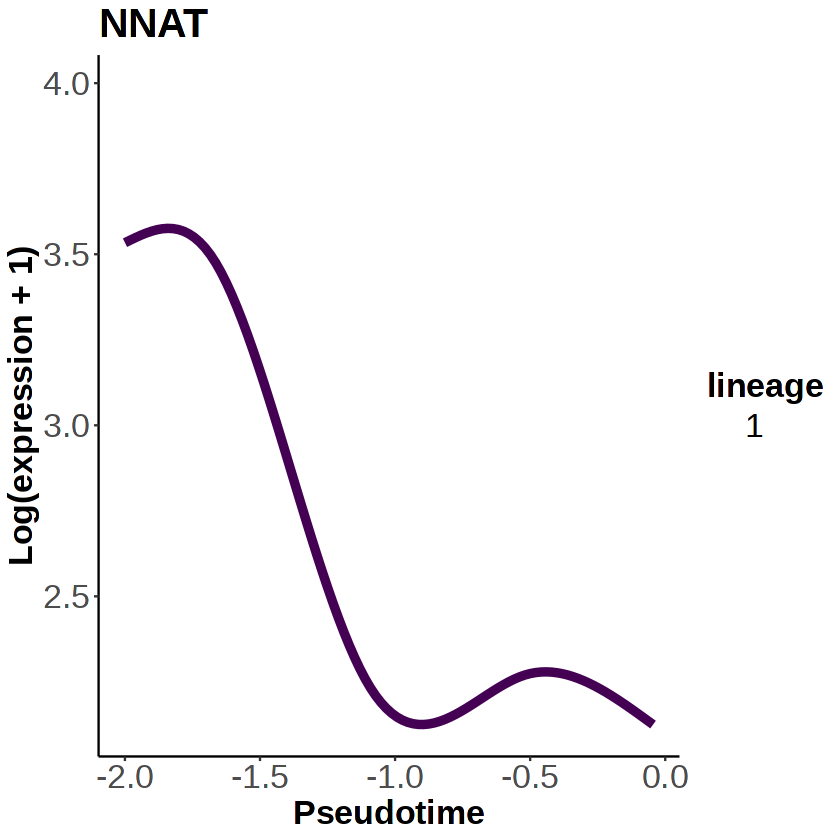

[1] "CCDC146"


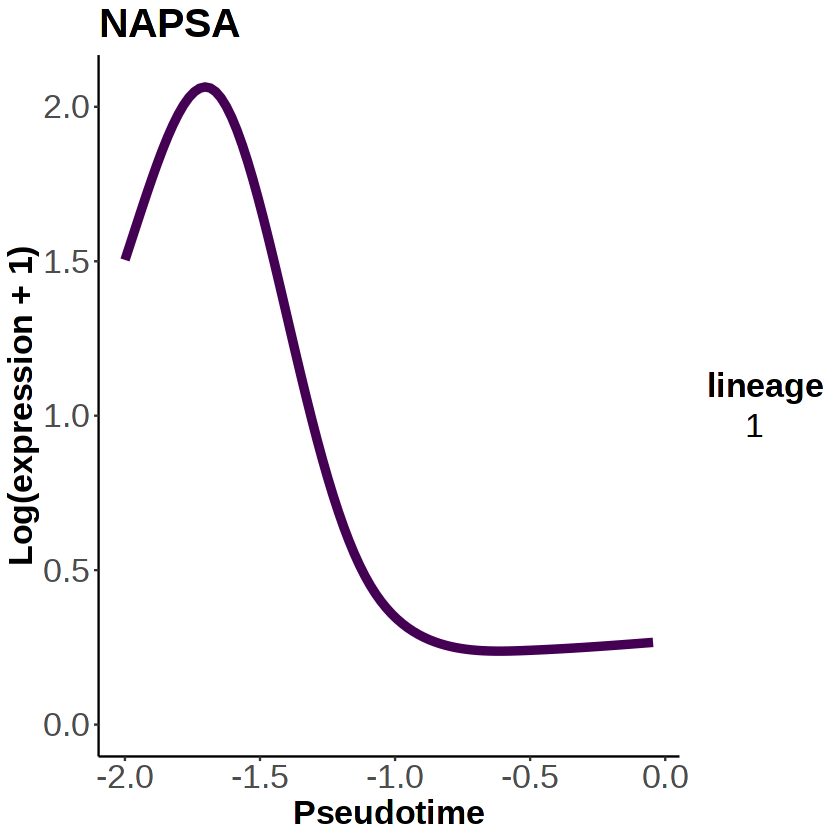

[1] "IL5RA"


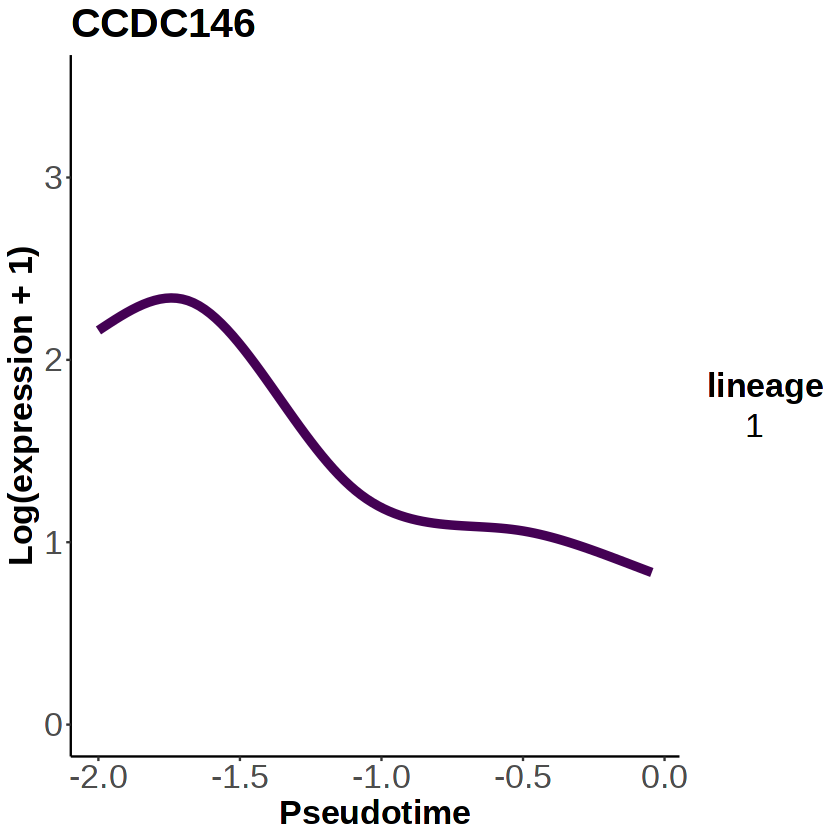

[1] "TMEM200C"


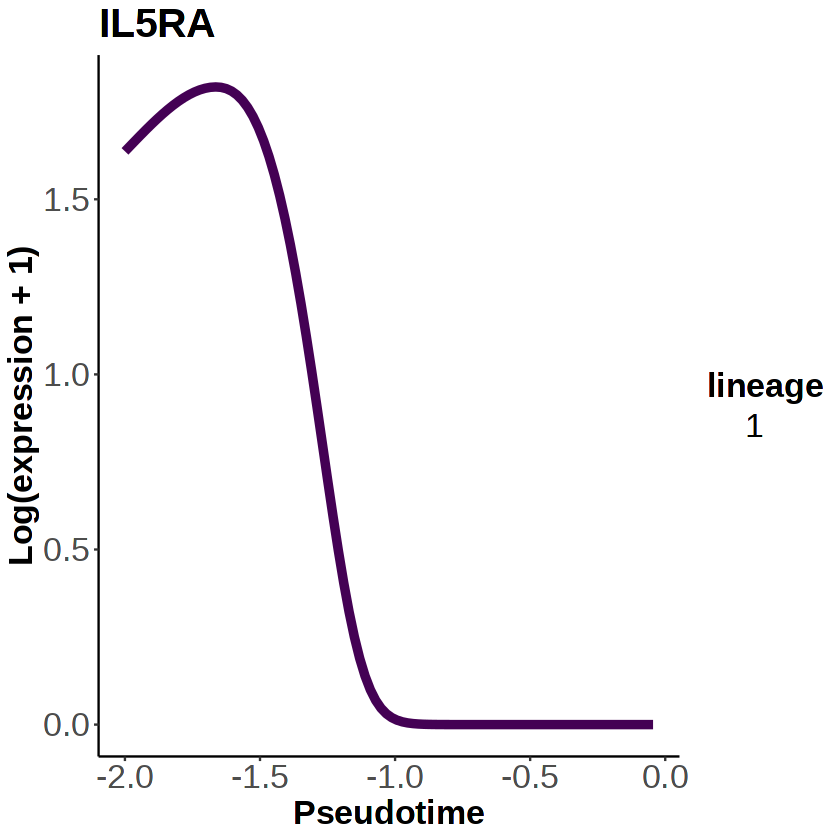

[1] "CFAP100"


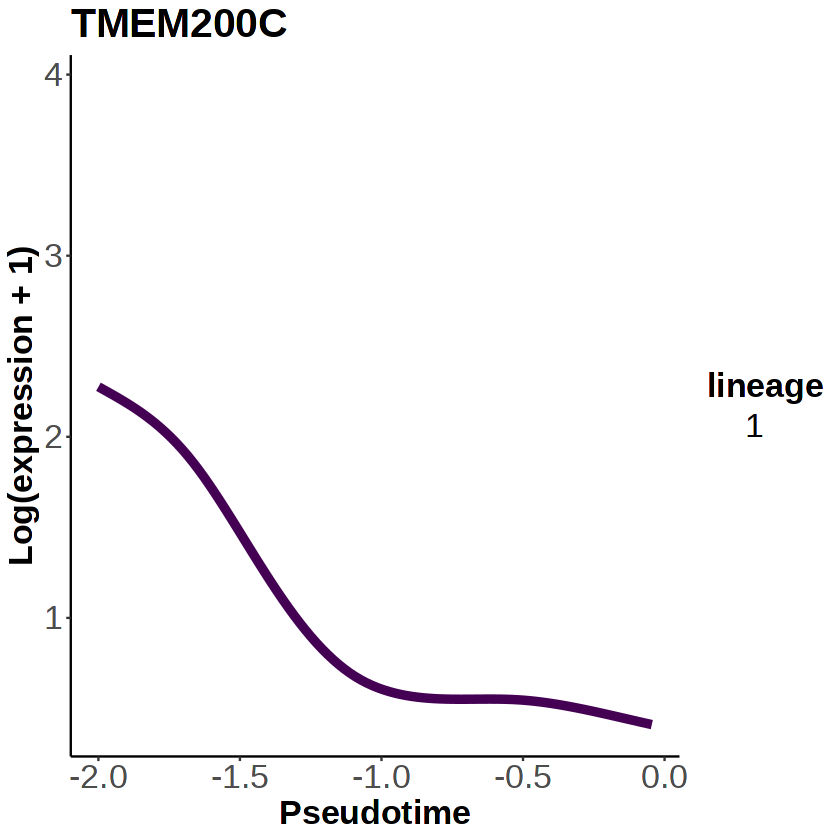

[1] "ID3"


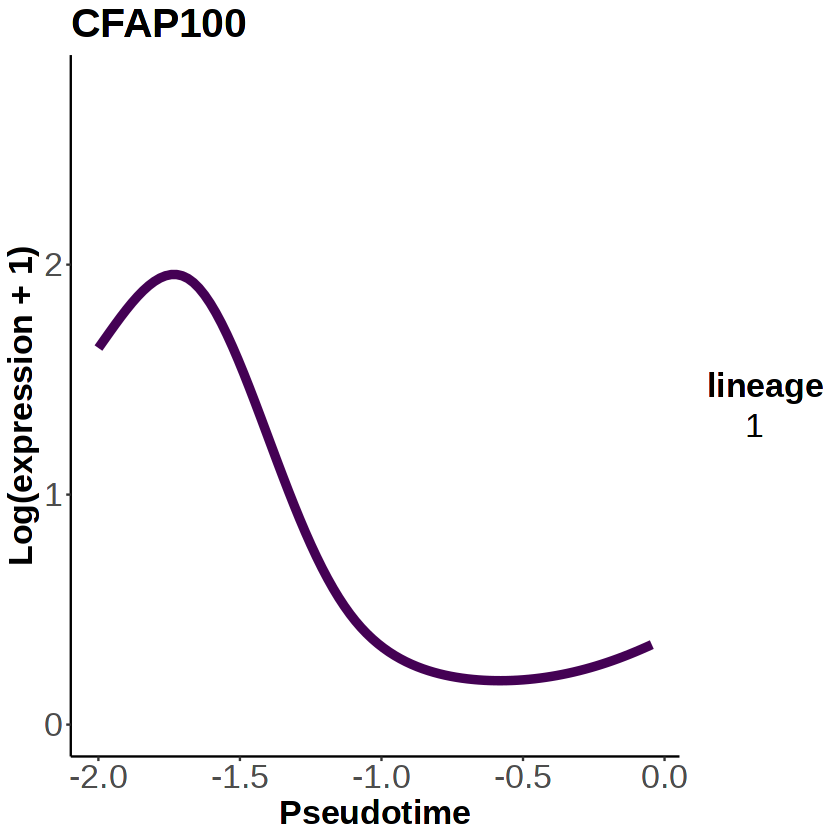

[1] "LMO2"


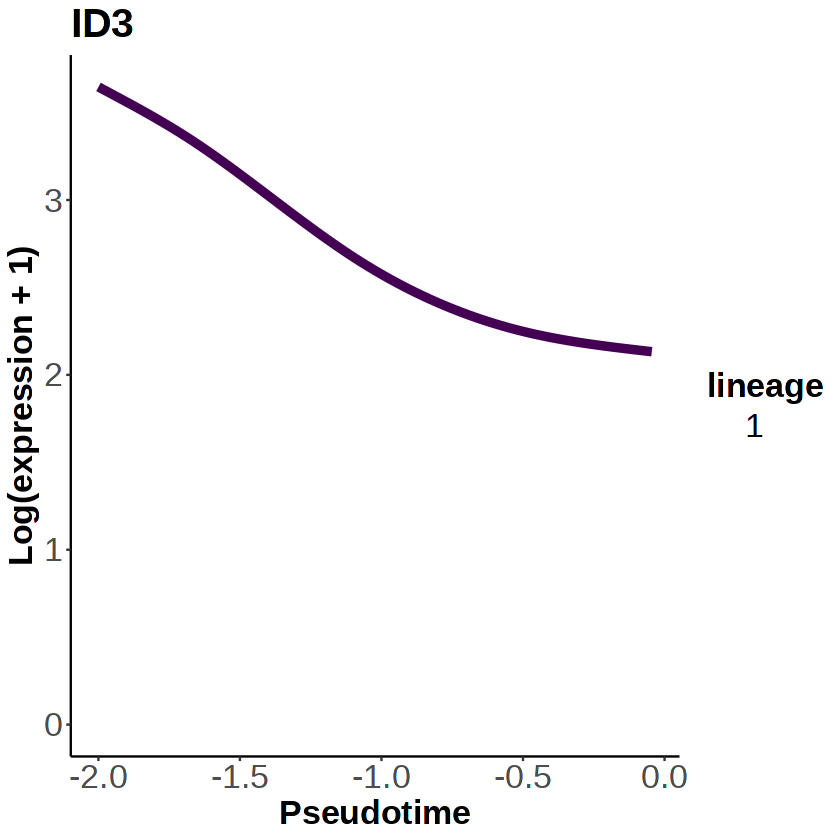

[1] "PRR29"


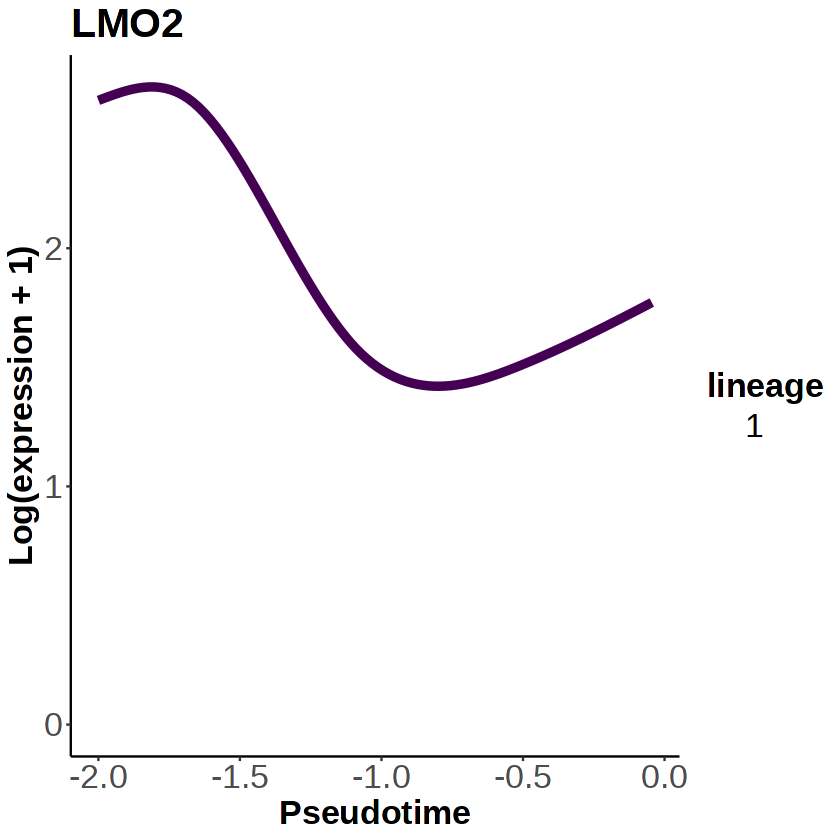

[1] "SLC39A5"


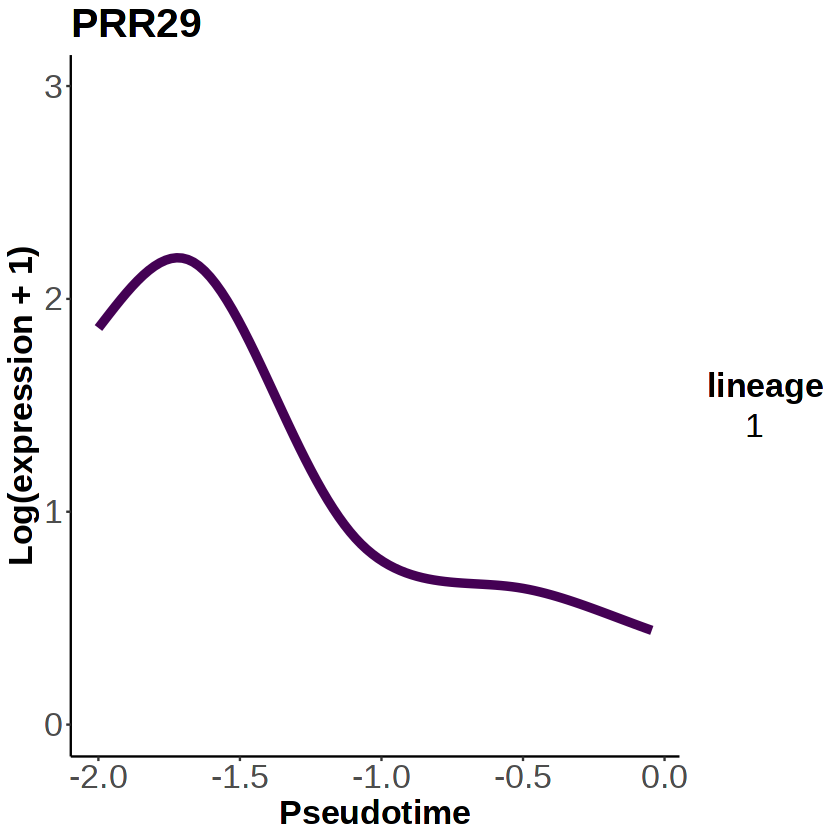

[1] "ACTG2"


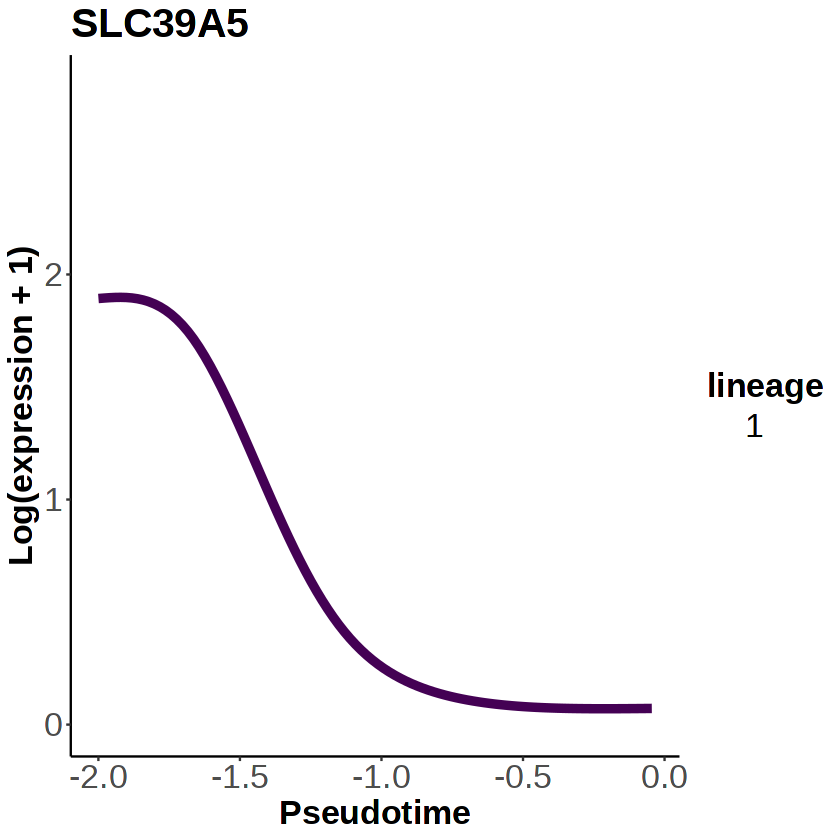

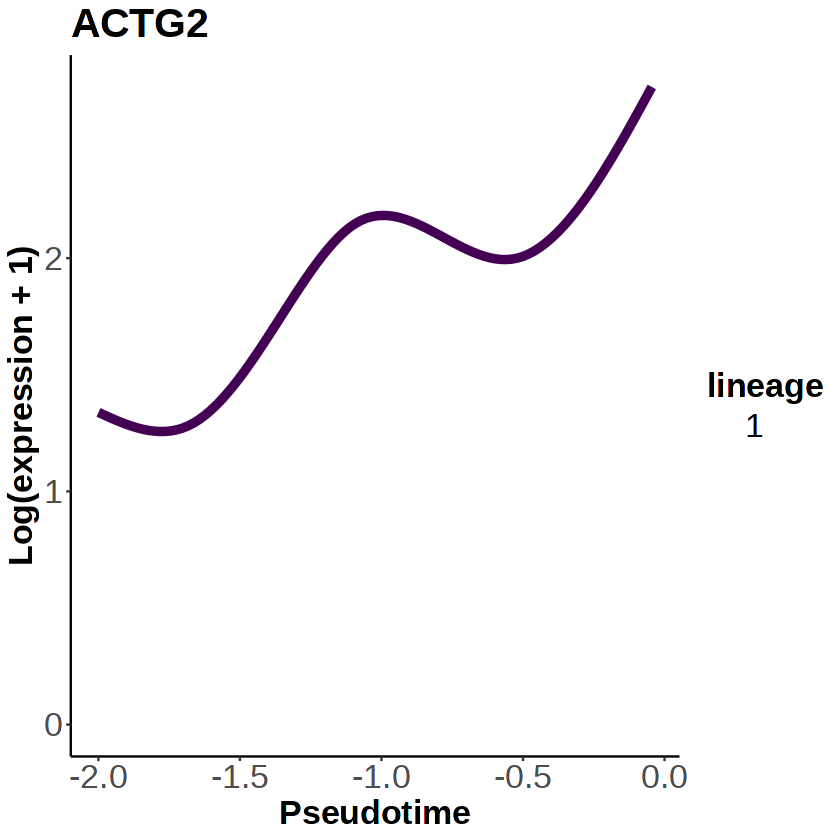

In [40]:
for (gene in tops) {
    print(gene)
    print(plotSmoothers(sce, counts, gene = gene, alpha = 0) + ggtitle(gene) +
                          theme(title = element_text(size = 20, face = 'bold'),
                                axis.title = element_text(size = 20),
                                axis.text = element_text(size = 20),
                                legend.text = element_text(size = 20),
                                legend.title = element_text(size = 20, face = "bold")))
}